# Imports

In [2]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt

import pickle
import os
import numpy as np
import pandas as pd
import time

from datasets import load_dataset
from huggingface_hub import hf_hub_download
from scipy.spatial import cKDTree

import itertools
import scipy as sp
from scipy.special import factorial, loggamma

/afs/glue.umd.edu/home/glue/p/a/pasand/home/miniconda3/envs/privatecf/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Entropy estimators

In [3]:
import warnings

import numpy as np
import numpy.linalg as la
from numpy import log
from scipy.special import digamma
from sklearn.neighbors import BallTree, KDTree

# CONTINUOUS ESTIMATORS


def entropy(x, k=3, base=2):
    """The classic K-L k-nearest neighbor continuous entropy estimator
    x should be a list of vectors, e.g. x = [[1.3], [3.7], [5.1], [2.4]]
    if x is a one-dimensional scalar and we have four samples
    """
    assert k <= len(x) - 1, "Set k smaller than num. samples - 1"
    x = np.asarray(x)
    n_elements, n_features = x.shape
    x = add_noise(x)
    tree = build_tree(x)
    nn = query_neighbors(tree, x, k)
    const = digamma(n_elements) - digamma(k) + n_features * log(2)
    return (const + n_features * np.log(nn).mean()) / log(base)


def centropy(x, y, k=3, base=2):
    """The classic K-L k-nearest neighbor continuous entropy estimator for the
    entropy of X conditioned on Y.
    """
    xy = np.c_[x, y]
    entropy_union_xy = entropy(xy, k=k, base=base)
    entropy_y = entropy(y, k=k, base=base)
    return entropy_union_xy - entropy_y


def tc(xs, k=3, base=2):
    xs_columns = np.expand_dims(xs, axis=0).T
    entropy_features = [entropy(col, k=k, base=base) for col in xs_columns]
    return np.sum(entropy_features) - entropy(xs, k, base)


def ctc(xs, y, k=3, base=2):
    xs_columns = np.expand_dims(xs, axis=0).T
    centropy_features = [centropy(col, y, k=k, base=base) for col in xs_columns]
    return np.sum(centropy_features) - centropy(xs, y, k, base)


def corex(xs, ys, k=3, base=2):
    xs_columns = np.expand_dims(xs, axis=0).T
    cmi_features = [mi(col, ys, k=k, base=base) for col in xs_columns]
    return np.sum(cmi_features) - mi(xs, ys, k=k, base=base)


def mi(x, y, z=None, k=3, base=2, alpha=0):
    """Mutual information of x and y (conditioned on z if z is not None)
    x, y should be a list of vectors, e.g. x = [[1.3], [3.7], [5.1], [2.4]]
    if x is a one-dimensional scalar and we have four samples
    """
    assert len(x) == len(y), "Arrays should have same length"
    assert k <= len(x) - 1, "Set k smaller than num. samples - 1"
    x, y = np.asarray(x), np.asarray(y)
    x, y = x.reshape(x.shape[0], -1), y.reshape(y.shape[0], -1)
    x = add_noise(x)
    y = add_noise(y)
    points = [x, y]
    if z is not None:
        z = np.asarray(z)
        z = z.reshape(z.shape[0], -1)
        points.append(z)
    points = np.hstack(points)
    # Find nearest neighbors in joint space, p=inf means max-norm
    tree = build_tree(points)
    dvec = query_neighbors(tree, points, k)
    if z is None:
        a, b, c, d = (
            avgdigamma(x, dvec),
            avgdigamma(y, dvec),
            digamma(k),
            digamma(len(x)),
        )
        if alpha > 0:
            d += lnc_correction(tree, points, k, alpha)
    else:
        xz = np.c_[x, z]
        yz = np.c_[y, z]
        a, b, c, d = (
            avgdigamma(xz, dvec),
            avgdigamma(yz, dvec),
            avgdigamma(z, dvec),
            digamma(k),
        )
    return (-a - b + c + d) / log(base)


def cmi(x, y, z, k=3, base=2):
    """Mutual information of x and y, conditioned on z
    Legacy function. Use mi(x, y, z) directly.
    """
    return mi(x, y, z=z, k=k, base=base)


def kldiv(x, xp, k=3, base=2):
    """KL Divergence between p and q for x~p(x), xp~q(x)
    x, xp should be a list of vectors, e.g. x = [[1.3], [3.7], [5.1], [2.4]]
    if x is a one-dimensional scalar and we have four samples
    """
    assert k < min(len(x), len(xp)), "Set k smaller than num. samples - 1"
    assert len(x[0]) == len(xp[0]), "Two distributions must have same dim."
    x, xp = np.asarray(x), np.asarray(xp)
    x, xp = x.reshape(x.shape[0], -1), xp.reshape(xp.shape[0], -1)
    d = len(x[0])
    n = len(x)
    m = len(xp)
    const = log(m) - log(n - 1)
    tree = build_tree(x)
    treep = build_tree(xp)
    nn = query_neighbors(tree, x, k)
    nnp = query_neighbors(treep, x, k - 1)
    return (const + d * (np.log(nnp).mean() - np.log(nn).mean())) / log(base)


def lnc_correction(tree, points, k, alpha):
    e = 0
    n_sample = points.shape[0]
    for point in points:
        # Find k-nearest neighbors in joint space, p=inf means max norm
        knn = tree.query(point[None, :], k=k + 1, return_distance=False)[0]
        knn_points = points[knn]
        # Substract mean of k-nearest neighbor points
        knn_points = knn_points - knn_points[0]
        # Calculate covariance matrix of k-nearest neighbor points, obtain eigen vectors
        covr = knn_points.T @ knn_points / k
        _, v = la.eig(covr)
        # Calculate PCA-bounding box using eigen vectors
        V_rect = np.log(np.abs(knn_points @ v).max(axis=0)).sum()
        # Calculate the volume of original box
        log_knn_dist = np.log(np.abs(knn_points).max(axis=0)).sum()

        # Perform local non-uniformity checking and update correction term
        if V_rect < log_knn_dist + np.log(alpha):
            e += (log_knn_dist - V_rect) / n_sample
    return e


# DISCRETE ESTIMATORS
def entropyd(sx, base=2):
    """Discrete entropy estimator
    sx is a list of samples
    """
    unique, count = np.unique(sx, return_counts=True, axis=0)
    # Convert to float as otherwise integer division results in all 0 for proba.
    proba = count.astype(float) / len(sx)
    # Avoid 0 division; remove probabilities == 0.0 (removing them does not change the entropy estimate as 0 * log(1/0) = 0.
    proba = proba[proba > 0.0]
    return np.sum(proba * np.log(1.0 / proba)) / log(base)


def midd(x, y, base=2):
    """Discrete mutual information estimator
    Given a list of samples which can be any hashable object
    """
    assert len(x) == len(y), "Arrays should have same length"
    return entropyd(x, base) - centropyd(x, y, base)


def cmidd(x, y, z, base=2):
    """Discrete mutual information estimator
    Given a list of samples which can be any hashable object
    """
    assert len(x) == len(y) == len(z), "Arrays should have same length"
    xz = np.c_[x, z]
    yz = np.c_[y, z]
    xyz = np.c_[x, y, z]
    return (
        entropyd(xz, base)
        + entropyd(yz, base)
        - entropyd(xyz, base)
        - entropyd(z, base)
    )


def centropyd(x, y, base=2):
    """The classic K-L k-nearest neighbor continuous entropy estimator for the
    entropy of X conditioned on Y.
    """
    xy = np.c_[x, y]
    return entropyd(xy, base) - entropyd(y, base)


def tcd(xs, base=2):
    xs_columns = np.expand_dims(xs, axis=0).T
    entropy_features = [entropyd(col, base=base) for col in xs_columns]
    return np.sum(entropy_features) - entropyd(xs, base)


def ctcd(xs, y, base=2):
    xs_columns = np.expand_dims(xs, axis=0).T
    centropy_features = [centropyd(col, y, base=base) for col in xs_columns]
    return np.sum(centropy_features) - centropyd(xs, y, base)


def corexd(xs, ys, base=2):
    xs_columns = np.expand_dims(xs, axis=0).T
    cmi_features = [midd(col, ys, base=base) for col in xs_columns]
    return np.sum(cmi_features) - midd(xs, ys, base)


# MIXED ESTIMATORS
def micd(x, y, k=3, base=2, warning=True):
    """If x is continuous and y is discrete, compute mutual information"""
    assert len(x) == len(y), "Arrays should have same length"
    entropy_x = entropy(x, k, base)

    y_unique, y_count = np.unique(y, return_counts=True, axis=0)
    y_proba = y_count / len(y)

    entropy_x_given_y = 0.0
    for yval, py in zip(y_unique, y_proba):
        x_given_y = x[(y == yval).all(axis=1)]
        if k <= len(x_given_y) - 1:
            entropy_x_given_y += py * entropy(x_given_y, k, base)
        else:
            if warning:
                warnings.warn(
                    "Warning, after conditioning, on y={yval} insufficient data. "
                    "Assuming maximal entropy in this case.".format(yval=yval)
                )
            entropy_x_given_y += py * entropy_x
    return abs(entropy_x - entropy_x_given_y)  # units already applied


def midc(x, y, k=3, base=2, warning=True):
    return micd(y, x, k, base, warning)


def centropycd(x, y, k=3, base=2, warning=True):
    return entropy(x, base) - micd(x, y, k, base, warning)


def centropydc(x, y, k=3, base=2, warning=True):
    return centropycd(y, x, k=k, base=base, warning=warning)


def ctcdc(xs, y, k=3, base=2, warning=True):
    xs_columns = np.expand_dims(xs, axis=0).T
    centropy_features = [
        centropydc(col, y, k=k, base=base, warning=warning) for col in xs_columns
    ]
    return np.sum(centropy_features) - centropydc(xs, y, k, base, warning)


def ctccd(xs, y, k=3, base=2, warning=True):
    return ctcdc(y, xs, k=k, base=base, warning=warning)


def corexcd(xs, ys, k=3, base=2, warning=True):
    return corexdc(ys, xs, k=k, base=base, warning=warning)


def corexdc(xs, ys, k=3, base=2, warning=True):
    return tcd(xs, base) - ctcdc(xs, ys, k, base, warning)


# UTILITY FUNCTIONS


def add_noise(x, intens=1e-10):
    # small noise to break degeneracy, see doc.
    return x + intens * np.random.random_sample(x.shape)


def query_neighbors(tree, x, k):
    return tree.query(x, k=k + 1)[0][:, k]


def count_neighbors(tree, x, r):
    return tree.query_radius(x, r, count_only=True)


def avgdigamma(points, dvec):
    # This part finds number of neighbors in some radius in the marginal space
    # returns expectation value of <psi(nx)>
    tree = build_tree(points)
    dvec = dvec - 1e-15
    num_points = count_neighbors(tree, points, dvec)
    return np.mean(digamma(num_points))


def build_tree(points):
    if points.shape[1] >= 20:
        return BallTree(points, metric="chebyshev")
    return KDTree(points, metric="chebyshev")


# TESTS


def shuffle_test(measure, x, y, z=False, ns=200, ci=0.95, **kwargs):
    """Shuffle test
    Repeatedly shuffle the x-values and then estimate measure(x, y, [z]).
    Returns the mean and conf. interval ('ci=0.95' default) over 'ns' runs.
    'measure' could me mi, cmi, e.g. Keyword arguments can be passed.
    Mutual information and CMI should have a mean near zero.
    """
    x_clone = np.copy(x)  # A copy that we can shuffle
    outputs = []
    for i in range(ns):
        np.random.shuffle(x_clone)
        if z:
            outputs.append(measure(x_clone, y, z, **kwargs))
        else:
            outputs.append(measure(x_clone, y, **kwargs))
    outputs.sort()
    return np.mean(outputs), (
        outputs[int((1.0 - ci) / 2 * ns)],
        outputs[int((1.0 + ci) / 2 * ns)],
    )

# Utility functions

In [6]:
def save_data(data, folder_path, filename):
    os.makedirs(folder_path, exist_ok=True)
    file_path = os.path.join(folder_path, filename)
    with open(file_path, 'wb') as f:
        pickle.dump(data, f)


def find_closest_cfs(cfs, queries, weights=None):
    if weights is not None:
        W_root = np.sqrt(np.diag(weights))
        weighted_cfs = cfs @ W_root
        weighted_queries = queries @ W_root
    else:
        weighted_cfs = cfs
        weighted_queries = queries
    # Create a KD-tree for points_b
    tree = cKDTree(weighted_cfs)
    # Find the closest point in points_b for each point in points_a
    distances, indices = tree.query(weighted_queries)
    # Get the closest points
    closest_points = cfs[indices]
    return closest_points, distances, np.array(indices)

def find_closest_cfs_with_immutables(cfs, queries, h):
    h = h.astype(bool)
    indices, distances, closest_points = [], [], []
    for q_id, q in enumerate(queries):
      matching_cf_ids = []
      for cf_id, cf in enumerate(cfs):
        if len(h.shape)==2 and (cf[h[q_id]] == q[h[q_id]]).all():
          matching_cf_ids.append(cf_id)
        elif len(h.shape)==1 and (cf[h] == q[h]).all():
          matching_cf_ids.append(cf_id)

      if len(matching_cf_ids) == 0:
        indices.append(None)
        distances.append(-1)
        closest_points.append(-1*np.ones_like(cfs[0]))
        continue

      matching_cfs = cfs[matching_cf_ids]
      tree = cKDTree(matching_cfs)
      # Find the closest point in points_b for each point in points_a
      distance, index = tree.query(q)
      index = matching_cf_ids[index]

      # Get the closest points
      closest_point = cfs[index]
      indices.append(index)
      distances.append(distance)
      closest_points.append(closest_point)
    distances = np.array(distances)
    indices = np.array(indices)
    closest_points = np.array(closest_points)
    return closest_points, distances, indices


def draw_samples(arr, n, replace=False):
    if replace:
        # Use np.random.choice for sampling with replacement
        indices = np.random.choice(len(arr), size=n, replace=True)
    else:
        # Use np.random.choice with replace=False for sampling without replacement
        indices = np.random.choice(len(arr), size=n, replace=False)
    return arr[indices]


def mod_inverse(a, m):
    """Compute the modular multiplicative inverse of a modulo m."""
    def egcd(a, b):
        if a == 0:
            return (b, 0, 1)
        else:
            g, y, x = egcd(b % a, a)
            return (g, x - (b // a) * y, y)

    g, x, _ = egcd(a, m)
    if g != 1:
        raise Exception('Modular inverse does not exist')
    else:
        return x % m


def matrix_inverse_2x2_finite_field(matrix, q):
    """
    Compute the inverse of a 2x2 matrix in GF(q).

    Parameters:
    matrix (numpy.ndarray): 2x2 matrix to invert
    q (int): Prime number defining the finite field GF(q)

    Returns:
    numpy.ndarray: Inverted 2x2 matrix in GF(q)
    """
    a, b, c, d = matrix.flatten()

    # Compute determinant
    det = (a * d - b * c) % q

    # Check if determinant is invertible
    try:
        det_inv = mod_inverse(det, q)
    except Exception:
        raise ValueError("Matrix is not invertible in GF({})".format(q))

    # Compute adjugate matrix
    adj = np.array([[d, -b], [-c, a]], dtype=int)

    # Compute inverse
    inv = (det_inv * adj) % q

    return inv


def matrix_inverse_3x3_finite_field(matrix, q):
    """
    Compute the inverse of a 3x3 matrix in GF(q).

    Parameters:
    matrix (list of lists): A 3x3 matrix represented as a list of lists
    q (int): The order of the finite field (must be prime)

    Returns:
    list of lists: The inverse matrix, or None if the matrix is not invertible
    """
    def mod_inverse(a, m):
        """Helper function to find modular multiplicative inverse"""
        for i in range(1, m):
            if (a * i) % m == 1:
                return i
        return None

    # Compute the determinant
    det = (matrix[0][0] * (matrix[1][1] * matrix[2][2] - matrix[1][2] * matrix[2][1])
           - matrix[0][1] * (matrix[1][0] * matrix[2][2] - matrix[1][2] * matrix[2][0])
           + matrix[0][2] * (matrix[1][0] * matrix[2][1] - matrix[1][1] * matrix[2][0])) % q

    # Check if the matrix is invertible
    if det == 0:
        return None

    # Compute the modular multiplicative inverse of the determinant
    det_inv = mod_inverse(det, q)
    if det_inv is None:
        return None

    # Compute the adjugate matrix
    adj = [
        [(matrix[1][1]*matrix[2][2] - matrix[1][2]*matrix[2][1]) % q,
         (matrix[0][2]*matrix[2][1] - matrix[0][1]*matrix[2][2]) % q,
         (matrix[0][1]*matrix[1][2] - matrix[0][2]*matrix[1][1]) % q],
        [(matrix[1][2]*matrix[2][0] - matrix[1][0]*matrix[2][2]) % q,
         (matrix[0][0]*matrix[2][2] - matrix[0][2]*matrix[2][0]) % q,
         (matrix[0][2]*matrix[1][0] - matrix[0][0]*matrix[1][2]) % q],
        [(matrix[1][0]*matrix[2][1] - matrix[1][1]*matrix[2][0]) % q,
         (matrix[0][1]*matrix[2][0] - matrix[0][0]*matrix[2][1]) % q,
         (matrix[0][0]*matrix[1][1] - matrix[0][1]*matrix[1][0]) % q]
    ]

    # Multiply the adjugate matrix by the inverse of the determinant
    inv = [[((det_inv * adj[i][j]) % q) for j in range(3)] for i in range(3)]

    return np.array(inv)


def unique_vectors(vectors):
    """Get unique vectors from a list of vectors."""
    # Convert the list of vectors to a 2D numpy array
    arr = np.array(vectors)
    # Use numpy.unique to get unique rows
    unique_arr = np.unique(arr, axis=0)
    return unique_arr


def compute_cf_accuracy_with_ids(db, x, q_cf_ids, raw_cf_ids):
  cf1 = db[q_cf_ids]
  cf2 = db[raw_cf_ids]
  n_correct = np.linalg.norm(cf1-x, ord=2, axis=1) <= np.linalg.norm(cf2-x, ord=2, axis=1)
  return np.mean(n_correct)


def compute_cf_accuracy(x, q_cfs, raw_cfs):
  n_correct = np.linalg.norm(q_cfs-x, ord=2, axis=1) <= np.linalg.norm(raw_cfs-x, ord=2, axis=1)
  return np.mean(n_correct)


def next_prime(n):
    def is_prime(num):
        if num < 2:
            return False
        for i in range(2, int(num**0.5) + 1):
            if num % i == 0:
                return False
        return True

    next_num = n + 1
    while True:
        if is_prime(next_num):
            return next_num
        next_num += 1


def same_order_largest_to_smallest(arr1, arr2):
    """
    Check if the order of elements from largest to smallest is the same in both arrays.

    Parameters:
    arr1 (list): First array
    arr2 (list): Second array

    Returns:
    bool: True if the order from largest to smallest is the same, False otherwise
    """
    if len(arr1) != len(arr2):
        return False

    # Create sorted indices for both arrays
    sorted_indices1 = sorted(range(len(arr1)), key=lambda k: arr1[k], reverse=True)
    sorted_indices2 = sorted(range(len(arr2)), key=lambda k: arr2[k], reverse=True)

    # Compare the sorted indices
    return sorted_indices1 == sorted_indices2


def normalize_array(arr, method='min-max', axis=0):
    """
    Normalize a 2D NumPy array column-wise.

    Parameters:
    arr (numpy.ndarray): The input 2D array
    method (str): Normalization method. Options are 'min-max', 'z-score', 'l1', 'l2'
    axis (int): The axis along which to normalize (0 for columns, 1 for rows)

    Returns:
    numpy.ndarray: Normalized array
    dict: Dictionary containing normalization parameters for each column
    """

    if arr.ndim != 2:
        raise ValueError("Input must be a 2D NumPy array")

    normalized_arr = np.zeros_like(arr, dtype=float)
    normalization_params = {}

    if method == 'min-max':
        min_vals = np.min(arr, axis=axis, keepdims=True)
        max_vals = np.max(arr, axis=axis, keepdims=True)
        normalized_arr = (arr - min_vals) / (max_vals - min_vals)
        normalization_params = {'min': min_vals, 'max': max_vals}

    elif method == 'z-score':
        mean = np.mean(arr, axis=axis, keepdims=True)
        std = np.std(arr, axis=axis, keepdims=True)
        normalized_arr = (arr - mean) / std
        normalization_params = {'mean': mean, 'std': std}

    elif method == 'l1':
        l1_norm = np.sum(np.abs(arr), axis=axis, keepdims=True)
        normalized_arr = arr / l1_norm
        normalization_params = {'l1_norm': l1_norm}

    elif method == 'l2':
        l2_norm = np.sqrt(np.sum(arr**2, axis=axis, keepdims=True))
        normalized_arr = arr / l2_norm
        normalization_params = {'l2_norm': l2_norm}

    else:
        raise ValueError("Invalid normalization method. Choose 'min-max', 'z-score', 'l1', or 'l2'.")

    return normalized_arr, normalization_params

def nPr_log(n, r):
    return np.exp(loggamma(n+1) - loggamma(n-r+1))

def generate_binary_vectors(length, weight):
    """Generates all binary vectors of specified length and Hamming weight."""
    vectors = []
    for positions in itertools.combinations(range(length), weight):
        vector = [0] * length
        for pos in positions:
            vector[pos] = 1
        vectors.append(vector)
    return np.array(vectors)

def unique_row_ids(arr):
    """
    Returns the indices of unique rows in a NumPy array.

    Args:
        arr (np.ndarray): The input NumPy array.

    Returns:
        np.ndarray: An array of indices corresponding to the unique rows in the input array.
    """
    # Convert the array to a structured array for comparison of rows
    struct_arr = arr.view(np.dtype((np.void, arr.dtype.itemsize * arr.shape[1])))
    
    # Find unique rows and their indices
    _, unique_indices = np.unique(struct_arr, return_index=True)
    
    return unique_indices

# Quantization schemes

In [7]:
# Define quantization schemes
class QuantizationScheme:
  def __init__(self, num_levels, db):
    self.quant_min, self.quant_max, self.step_size = [], [], []
    self.num_levels = num_levels
    self.quant_maps = {}
    for column_id in range(db.shape[1]):
      column = db[:,column_id]
      self.quant_min.append(column.min())
      self.quant_max.append(column.max())
      col_step_size = (self.quant_max[column_id] - self.quant_min[column_id]) / (self.num_levels - 1)
      self.step_size.append(col_step_size)

      quant_map = {}
      for i in range(num_levels):
          lower_bound = column.min() + i * col_step_size
          upper_bound = lower_bound + col_step_size
          symbol = i
          quant_map[symbol] = (lower_bound, upper_bound)
          self.quant_maps[column_id] = quant_map

  def quantize_value(self, value, quant_map):
    #Quantize a single value using the quantization map.
    for symbol, (lower, upper) in quant_map.items():
        if lower <= value < upper:
            return symbol
    return list(quant_map.keys())[-1]

  def quantize(self, dataset):
      # Perform uniform quantization on each column of the dataset.
      quantized_dataset = dataset.copy()
      if dataset.shape[1] != len(self.quant_maps.keys()):
        raise Exception(f'quantization no. of cols mismatch: input cols={dataset.shape[1]}, init cols={len(self.quant_maps.keys())}')
      for column, quant_map in self.quant_maps.items():
        qfunc = lambda x: self.quantize_value(x, quant_map)
        quantized_dataset[:,column] = np.array([qfunc(v) for v in dataset[:,column]])
      return quantized_dataset

# Retrieval schemes

## Vanilla

In [8]:
class RetrievalSchemeVanilla:
  def __init__(self, db, q, d):
    self.db = db
    self.q = q
    self.d = d
    self.alpha1 = 1
    self.alpha2 = 2
    self.alpha3 = 3

  def noise(self, x=None):
    if x is None:
      return np.random.randint(low=0, high=self.q)
    else:
      return np.random.randint(low=0, high=self.q, size=x.shape)

  def Vandermonde_3x3_inverse(self, alpha1, alpha2, alpha3, q):
    a = np.array([alpha1, alpha2, alpha3])
    det=(a[0]-a[1])*(a[1]-a[2])*(a[2]-a[0]) % q
    cofactor=np.zeros((3,3), dtype = int)
    inv_matrix=np.zeros((3,3), dtype = int)
    cofactor[0,:] = [a[1]*a[2]*(a[2]-a[1]), (a[1]-a[2])*(a[1]+a[2]), a[2]-a[1]]
    cofactor[1,:] = [a[0]*a[2]*(a[2]-a[0]), (a[2]-a[0])*(a[0]+a[2]), a[0]-a[2]]
    cofactor[2,:] = [a[0]*a[1]*(a[1]-a[0]), (a[0]-a[1])*(a[1]+a[0]), a[1]-a[0]]
    inv_matrix = (mod_inverse(det, q)*cofactor) % q
    return inv_matrix

  def get_closest_cf_ids(self, x):
    z = self.noise(x)
    q1 = x + self.alpha1 * z
    q2 = x + self.alpha2 * z

    a1, a2, z_prime = [], [], self.noise()
    for q in q1:
      a1.append([np.sum((y-q)**2) + self.alpha1 * z_prime for y in self.db])
    for q in q2:
      a2.append([np.sum((y-q)**2) + self.alpha2 * z_prime for y in self.db])

    a1 = np.array(a1) % self.q
    a2 = np.array(a2) % self.q

    # print(f'a1={a1}')
    # print(f'a2={a2}\n')
    V = np.array([[1, self.alpha1], [1, self.alpha2]])
    V_inv = matrix_inverse_2x2_finite_field(V, self.q).astype(np.int64)
    # print(f'V_inv=\n{V_inv}\n')
    indices = []
    for i,q in enumerate(x):
      # print(f'i={i}')
      norm2_z = np.sum(z[i]**2) % self.q
      A = np.round(np.concatenate([a1[i].reshape(1,-1)-self.alpha1**2 * norm2_z, a2[i].reshape(1,-1)-self.alpha2**2 * norm2_z], axis=0) % self.q).astype(np.int64)
      # print(f'A=\n{A}e\n')
      D = (V_inv @ A) % self.q
      # print(f'D=\n{D}')
      # print(f'D=\n{D.astype(np.int64)}\n')
      indices.append(np.argmin(D[0]))

    return np.array(indices), np.array(D[0])

## Weighted

In [9]:
class RetrievalSchemeWeighted(RetrievalSchemeVanilla):
  def __init__(self, db, q, d, L):
    super().__init__(db, q, d)
    self.L = L


  def get_closest_cf_ids(self, x, w=None):
    if w is None:
      w = np.ones_like(x[0])
    # w = np.random.randint(low = 1, high = L, replace=True)
    if not np.all(w <= self.L):
      print(f'invalid weights: w={w}, L={self.L}')
      return None

    z1 = self.noise(x)
    z2 = self.noise(w)
    q11 = x + self.alpha1 * z1
    q12 = w + self.alpha1 * z2
    q21 = x + self.alpha2 * z1
    q22 = w + self.alpha2 * z2
    q31 = x + self.alpha3 * z1
    q32 = w + self.alpha3 * z2

    a1, a2, a3, z1_prime, z2_prime = [], [], [], self.noise(), self.noise()
    for q in q11:
      a1.append([np.sum((y-q).T @ np.diag(q12) @ (y-q)) + self.alpha1 * z1_prime + self.alpha1 * z2_prime for y in self.db])
    for q in q21:
      a2.append([np.sum((y-q).T @ np.diag(q22) @ (y-q)) + self.alpha2 * z1_prime + self.alpha2 * z2_prime for y in self.db])
    for q in q31:
      a3.append([np.sum((y-q).T @ np.diag(q32) @ (y-q)) + self.alpha3 * z1_prime + self.alpha3 * z2_prime for y in self.db])

    a1 = np.array(a1) % self.q
    a2 = np.array(a2) % self.q
    a3 = np.array(a3) % self.q

    # print(f'a1={a1}')
    # print(f'a2={a2}\n')
    V = np.array([[1, self.alpha1, self.alpha1**2], [1, self.alpha2, self.alpha2**2], [1, self.alpha3, self.alpha3**2]])
    # V_inv = self.Vandermonde_3x3_inverse(self.alpha1, self.alpha2, self.alpha3, self.q).astype(np.int64)
    V_inv = matrix_inverse_3x3_finite_field(V, self.q).astype(np.int64)
    # print(f'V_inv=\n{V_inv}\n')
    indices = []
    for i,q in enumerate(x):
      # print(f'i={i}')
      norm2_z1z2 = (z1[i].T @ np.diag(z2) @ z1[i]) % self.q
      A = np.round(np.concatenate([a1[i].reshape(1,-1)-self.alpha1**3 * norm2_z1z2, a2[i].reshape(1,-1)-self.alpha2**2 * norm2_z1z2, a3[i].reshape(1,-1)-self.alpha3**2 * norm2_z1z2], axis=0) % self.q).astype(np.int64)
      # print(f'A=\n{A}e\n')
      D = (V_inv @ A) % self.q
      # print(f'D=\n{D}')
      # print(f'D=\n{D.astype(np.int64)}\n')
      indices.append(np.argmin(D[0]))

    return np.array(indices), np.array(D[0])

## Masked

In [10]:
class RetrievalSchemeMasked(RetrievalSchemeVanilla):
  def __init__(self, db, q, d, d_min):
    super().__init__(db, q, d)
    self.d_min = d_min

  def get_closest_cf_ids(self, x):
    z = self.noise(x)
    q1 = x + self.alpha1 * z
    q2 = x + self.alpha2 * z

    a1, a2, z_prime = [], [], self.noise()
    for q in q1:
      a1.append([np.sum((y-q)**2) + self.alpha1 * z_prime + np.random.randint(0,self.d_min) for y in self.db])
    for q in q2:
      a2.append([np.sum((y-q)**2) + self.alpha2 * z_prime + np.random.randint(0,self.d_min) for y in self.db])

    a1 = np.array(a1) % self.q
    a2 = np.array(a2) % self.q

    # print(f'a1={a1}')
    # print(f'a2={a2}\n')
    V = np.array([[1, self.alpha1], [1, self.alpha2]])
    V_inv = matrix_inverse_2x2_finite_field(V, self.q).astype(np.int64)
    # print(f'V_inv=\n{V_inv}\n')
    indices = []
    additional_info = []
    for i,q in enumerate(x):
      # print(f'i={i}')
      norm2_z = np.sum(z[i]**2) % self.q
      A = np.round(np.concatenate([a1[i].reshape(1,-1)-self.alpha1**2 * norm2_z, a2[i].reshape(1,-1)-self.alpha2**2 * norm2_z], axis=0) % self.q).astype(np.int64)
      # print(f'A=\n{A}e\n')
      D = (V_inv @ A) % self.q
      # print(f'D=\n{D}')
      # print(f'D=\n{D.astype(np.int64)}\n')
      indices.append(np.argmin(D[0]))
      additional_info.append(D[0])

    return np.array(indices), np.array(additional_info)

## Two-phase immutable

In [11]:
class RetrievalSchemeTwoPhaseImmutable(RetrievalSchemeVanilla):
  def __init__(self, db, q, d):
    super().__init__(db, q, d)

  def get_closest_cf_ids(self, x, h1):
    z1 = self.noise(x)
    z2 = self.noise(x)

    Q11 = h1 + self.alpha1 * z1
    Q12 = h1 * x + self.alpha1 * z2
    Q21 = h1 + self.alpha2 * z1
    Q22 = h1 * x + self.alpha2 * z2
    Q31 = h1 + self.alpha3 * z1
    Q32 = h1 * x + self.alpha3 * z2

    a1, a2, a3, z1_prime, z2_prime = [], [], [], self.noise(), self.noise()
    rho = np.random.randint(low=1, high=self.q, size=self.db.shape[0])
    # for q11, q12 in zip(Q11, Q12):
    #   a1.append([rho_i * np.sum((q11*y_i - q12)**2) + self.alpha1 * z1_prime + self.alpha1**2 * z2_prime for rho_i, y_i in zip(rho, self.db)])
    # for q21, q22 in zip(Q21, Q22):
    #   a2.append([rho_i * np.sum((q21*y_i - q22)**2) + self.alpha2 * z1_prime + self.alpha2**2 * z2_prime for rho_i, y_i in zip(rho, self.db)])
    # for q31, q32 in zip(Q31, Q32):
    #   a3.append([rho_i * np.sum((q31*y_i - q32)**2) + self.alpha3 * z1_prime + self.alpha3**2 * z2_prime for rho_i, y_i in zip(rho, self.db)])

    for q11, q12 in zip(Q11, Q12):
      a1.append([rho_i * np.sum((q11*y_i - q12)**2 % self.q) + self.alpha1 * z1_prime + self.alpha1**2 * z2_prime for rho_i, y_i in zip(rho, self.db)])
    for q21, q22 in zip(Q21, Q22):
      a2.append([rho_i * np.sum((q21*y_i - q22)**2 % self.q) + self.alpha2 * z1_prime + self.alpha2**2 * z2_prime for rho_i, y_i in zip(rho, self.db)])
    for q31, q32 in zip(Q31, Q32):
      a3.append([rho_i * np.sum((q31*y_i - q32)**2 % self.q) + self.alpha3 * z1_prime + self.alpha3**2 * z2_prime for rho_i, y_i in zip(rho, self.db)])

    a1 = np.array(a1) % self.q
    a2 = np.array(a2) % self.q
    a3 = np.array(a3) % self.q

    # print(f'a1={a1}\n')
    # print(f'a2={a2}\n')
    # print(f'a3={a3}\n')
    # print(a1.shape, a2.shape, a3.shape)

    V = np.array([[1, self.alpha1, self.alpha1**2], [1, self.alpha2, self.alpha2**2], [1, self.alpha3, self.alpha3**2]])
    V_inv = matrix_inverse_3x3_finite_field(V, self.q)
    # print('the product:\n', (V_inv @ V) % self.q, '\n')

    h2 = []
    for i,_ in enumerate(x):
      A = np.round(np.concatenate([a1[i].reshape(1,-1), a2[i].reshape(1,-1), a3[i].reshape(1,-1)], axis=0) % self.q).astype(np.int64)
      D = (V_inv @ A) % self.q
      h2.append(D[0]==0)

    h2 = np.array(h2).astype(int)
    # print('h2:\n', h2, '\n')

    z3 = self.noise(h2)
    z4 = self.noise(x)

    R11 = h2 + self.alpha1 * z3
    R12 = x + self.alpha1 * z4
    R21 = h2 + self.alpha2 * z3
    R22 = x + self.alpha2 * z4
    R31 = h2 + self.alpha3 * z3
    R32 = x + self.alpha3 * z4

    b1, b2, b3, z3_prime, z4_prime = [], [], [], self.noise(), self.noise()
    # for r11, r12 in zip(R11, R12):
    #   S1 = np.diag(r11) @ self.db
    #   b1.append([np.sum((S1[i] - r12)**2) + self.alpha1 * z3_prime + self.alpha1**2 * z4_prime for i, y_i in enumerate(self.db)])
    # for r21, r22 in zip(R21, R22):
    #   S2 = np.diag(r21) @ self.db
    #   b2.append([np.sum((S2[i] - r22)**2) + self.alpha2 * z3_prime + self.alpha2**2 * z4_prime for i, y_i in enumerate(self.db)])
    # for r31, r32 in zip(R31, R32):
    #   S3 = np.diag(r31) @ self.db
    #   b3.append([np.sum((S3[i] - r32)**2) + self.alpha3 * z3_prime + self.alpha3**2 * z4_prime for i, y_i in enumerate(self.db)])

    for r11, r12 in zip(R11, R12):
      S1 = np.diag(r11) @ self.db
      b1.append([np.sum((S1[i] - r12)**2 % self.q) + self.alpha1 * z3_prime + self.alpha1**2 * z4_prime for i, y_i in enumerate(self.db)])
    for r21, r22 in zip(R21, R22):
      S2 = np.diag(r21) @ self.db
      b2.append([np.sum((S2[i] - r22)**2 % self.q) + self.alpha2 * z3_prime + self.alpha2**2 * z4_prime for i, y_i in enumerate(self.db)])
    for r31, r32 in zip(R31, R32):
      S3 = np.diag(r31) @ self.db
      b3.append([np.sum((S3[i] - r32)**2 % self.q) + self.alpha3 * z3_prime + self.alpha3**2 * z4_prime for i, y_i in enumerate(self.db)])

    b1 = np.array(b1) % self.q
    b2 = np.array(b2) % self.q
    b3 = np.array(b3) % self.q

    indices = []
    for i,_ in enumerate(x):
      B = np.round(np.concatenate([b1[i].reshape(1,-1), b2[i].reshape(1,-1), b3[i].reshape(1,-1)], axis=0) % self.q).astype(np.int64)
      D = (V_inv @ B) % self.q
      # print(f'D0={D[0]}, summed:{D[0] + self.q*(1-h2[i])}')
      if sum(h2[i]) < 1:
        indices.append(None)
      else:
        indices.append(np.argmin(D[0] + self.q*(1-h2[i])))
    # print(indices)
    return np.array(indices), np.array(D[0])

## Single-phase immutable

In [12]:
class RetrievalSchemeSinglePhaseImmutable(RetrievalSchemeVanilla):
  def __init__(self, db, q, d, L):
    super().__init__(db, q, d)
    self.L = L

  def get_closest_cf_ids(self, x, w):
    z1 = self.noise(x).astype(np.int64)
    z2 = self.noise(x).astype(np.int64)

    Q11 = w + self.alpha1 * z1
    Q12 = x + self.alpha1 * z2
    Q21 = w + self.alpha2 * z1
    Q22 = x + self.alpha2 * z2
    Q31 = w + self.alpha3 * z1
    Q32 = x + self.alpha3 * z2

    a1, a2, a3, z1_prime, z2_prime = [], [], [], self.noise(), self.noise()
    for j in range(len(x)):
      q11, q12 = Q11[j], Q12[j]
      a1.append([np.mod(np.mod((y_i-q12).T @ np.diag(q11), self.q) @ (y_i-q12), self.q)
                 + self.alpha1 * z1_prime + self.alpha1**2 * z2_prime
                - np.mod(self.alpha1**3 * z2[j].T @ np.diag(z1[j]) @ z2[j], self.q) for y_i in self.db])

      q21, q22 = Q21[j], Q22[j]
      a2.append([np.mod(np.mod((y_i-q22).T @ np.diag(q21), self.q) @ (y_i-q22), self.q)
                  + self.alpha2 * z1_prime + self.alpha2**2 * z2_prime
                 - np.mod(self.alpha2**3 * z2[j].T @ np.diag(z1[j]) @ z2[j], self.q) for y_i in self.db])

      q31, q32 = Q31[j], Q32[j]
      a3.append([np.mod(np.mod((y_i-q32).T @ np.diag(q31), self.q) @ (y_i-q32), self.q)
                  + self.alpha3 * z1_prime + self.alpha3**2 * z2_prime
                 - np.mod(self.alpha3**3 * z2[j].T @ np.diag(z1[j]) @ z2[j], self.q) for y_i in self.db])
      # q11, q12 = Q11[j], Q12[j]
      # a1.append([((y_i-q12).T @ np.diag(q11) @ (y_i-q12)) % self.q + (self.alpha1 * z1_prime) % self.q + (self.alpha1**2 * z2_prime) % self.q - (self.alpha1**3 * z2[j].T @ np.diag(z1[j]) @ z2[j]) % self.q for y_i in self.db])
      # q21, q22 = Q21[j], Q22[j]
      # a2.append([((y_i-q22).T @ np.diag(q21) @ (y_i-q22)) % self.q + (self.alpha2 * z1_prime) % self.q + (self.alpha2**2 * z2_prime) % self.q - (self.alpha2**3 * z2[j].T @ np.diag(z1[j]) @ z2[j]) % self.q for y_i in self.db])
      # q31, q32 = Q31[j], Q32[j]
      # a3.append([((y_i-q32).T @ np.diag(q31) @ (y_i-q32)) % self.q + (self.alpha3 * z1_prime) % self.q + (self.alpha3**2 * z2_prime) % self.q - (self.alpha3**3 * z2[j].T @ np.diag(z1[j]) @ z2[j]) % self.q for y_i in self.db])

    a1 = np.mod(np.array(a1), self.q)
    a2 = np.mod(np.array(a2), self.q)
    a3 = np.mod(np.array(a3), self.q)

    # print(f'a1={a1}\n')
    # print(f'a2={a2}\n')
    # print(f'a3={a3}\n')
    # print(a1.shape, a2.shape, a3.shape)

    V = np.array([[1, self.alpha1, self.alpha1**2], [1, self.alpha2, self.alpha2**2], [1, self.alpha3, self.alpha3**2]])
    V_inv = matrix_inverse_3x3_finite_field(V, self.q).astype(np.int64)
    # print('the product:\n', (V_inv @ V) % self.q, '\n')

    indices = []
    for i,_ in enumerate(x):
      A = np.round(np.concatenate([a1[i].reshape(1,-1), a2[i].reshape(1,-1), a3[i].reshape(1,-1)], axis=0)).astype(np.int64)
      D = (V_inv @ A) % self.q
      # print(f'D0={D[0]}')
      if (D[0] >= self.L).all():
        indices.append(None)
      else:
        indices.append(np.argmin(D[0]))

    return np.array(indices), np.array(D[0])

# Test retrieval schemes

In [ ]:
# test retrieval scheme
high = 5
d = 20
n_immutables = 2

db = unique_vectors(np.random.randint(low=0, high=high, size=(100,d)))
# db = np.array([
#     [1, 1, 1],
#     [4, 2, 3],
#     [2, 2, 5],
#     [3, 2, 2]
# ])

x = np.random.randint(low=0, high=high, size=(50,d))
# x = np.array([
#     [2, 2, 2],
#     [2, 2, 2],
# ])




L = high**2 * d + 1
q = next_prime(L*high**2*d)

h = np.concatenate([np.ones((len(x),n_immutables)), np.zeros((len(x), d-n_immutables))], axis=1)
[np.random.shuffle(h_row) for h_row in h]

# print('x:\n', x, '\n')
# print('db:\n', db, '\n')
# print('h\n', h, '\n')

print(f'q={q}, L={L}, d={d}')

# scheme = RetrievalSchemeTwoPhaseImmutable(db, next_prime(high**2*3), 3)
scheme1 = RetrievalSchemeSinglePhaseImmutable(db, q, d, L)
cf1 = scheme1.get_closest_cf_ids(x, h*(L-1)+1)[0]

scheme2 = RetrievalSchemeTwoPhaseImmutable(db, q, d)
cf2 = scheme2.get_closest_cf_ids(x, h)[0]


cfe = find_closest_cfs_with_immutables(db, x, h)[2]

is_equal1 = (cf1==cfe).astype(int)
is_equal2 = (cf2==cfe).astype(int)

print(f'cf1_ids={cf1}\n cf2_ids={cf2}\n cfe_ids={cfe}\n is_equal1={is_equal1}\n is_equal2={is_equal2}')
print(f'matches1={np.sum(is_equal1)/len(is_equal1)}, matches2={np.sum(is_equal2)/len(is_equal2)}')

cf1_valid = cf1[cf1 != None].astype(int)
cf2_valid = cf2[cf2 != None].astype(int)
cfe_valid = cfe[cfe != None].astype(int)
acc1 = compute_cf_accuracy(x[cf1 != None], db[cf1_valid], db[cfe_valid])
acc2 = compute_cf_accuracy(x[cf2 != None], db[cf2_valid], db[cfe_valid])

print(f'acc1={acc1}, acc2={acc2}')

# uneq_x = x[is_equal<1,:]
# uneq_cf1 = cf1[is_equal<1]
# uneq_cf2 = cf2[is_equal<1]

# for i in range(len(uneq_x)):
#   d1 = np.sum((uneq_x[i]-db[uneq_cf1[i]])**2)
#   d2 = np.sum((uneq_x[i]-db[uneq_cf2[i]])**2)
#   print(f'x={uneq_x[i]}, cf1={db[uneq_cf1[i]]}, d1={d1}, cf2={db[uneq_cf2[i]]}, d2={d2}, diff={d1-d2}')

# print(f'accuracy={compute_cf_accuracy_with_ids(db, x, cf1, cf2)}')

# for i in range(len(x)):
#   print(f'x={x[i]}, cf1_id={cf1[i]}, cf2_id={cf2[i]}, cf1={db[cf1[i]]}, cf2={db[cf2[i]]}')


q=250501, L=501, d=20
cf1_ids=[28 52 47 56 68 39 8 4 88 9 30 19 59 14 84 33 88 52 56 73 18 43 13 47 64
 94 39 66 17 56 29 12 58 92 66 40 42 19 93 None 91 52 39 65 6 69 4 44 None
 95]
 cf2_ids=[28 52 47 56 68 39 8 4 88 9 30 19 59 14 84 33 88 52 56 73 18 43 13 47 64
 94 39 66 17 56 29 12 58 92 66 40 42 19 93 None 91 52 39 65 6 69 4 44 None
 95]
 cfe_ids=[28 52 47 56 68 39 8 4 88 9 30 19 59 14 84 33 88 52 56 73 18 43 13 47 64
 94 39 66 17 56 29 12 58 92 66 40 42 19 93 None 91 52 39 65 6 69 4 44 None
 95]
 is_equal1=[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
 is_equal2=[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
matches1=1.0, matches2=1.0
acc1=1.0, acc2=1.0


# Dataset

## Wine

In [11]:
# load the dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv"
wine_df = pd.read_csv(url, sep=';')
print(wine_df.shape)

(4898, 12)


In [12]:
# split target and features
X = wine_df.drop('quality', axis=1).to_numpy()
X = normalize_array(X)[0]
y = wine_df['quality'].to_numpy()
y = (y >= 5).astype(int)

## COMPAS

In [13]:
dataset = load_dataset("imodels/compas-recidivism")
# Convert the 'train' split to a pandas DataFrame
df = pd.DataFrame(dataset['train'])

In [14]:
# split target and features
X = df.drop('is_recid', axis=1).to_numpy()
X = normalize_array(X)[0]
y = df['is_recid'].to_numpy()

# Test quantizer

[[0.28205128 0.         0.48333333 0.00125    0.         0.
  0.         0.         1.         0.         0.         1.
  0.         0.         0.         1.         0.         0.
  0.         1.        ]
 [0.08974359 0.02702703 0.48333333 0.0025     0.         0.
  0.         1.         0.         0.         0.         0.
  0.         0.         1.         1.         0.         0.
  0.         1.        ]
 [0.23076923 0.2972973  0.48333333 0.00375    0.         0.
  0.         0.         1.         0.         0.         1.
  0.         0.         0.         1.         0.         0.
  0.         1.        ]
 [0.06410256 0.02702703 0.48333333 0.00125    0.         0.
  0.07692308 0.         1.         0.         0.         1.
  0.         0.         0.         0.         0.         1.
  0.         1.        ]
 [0.14102564 0.         0.5        0.         0.         0.
  0.         0.         1.         0.         0.         1.
  0.         0.         0.         1.         0.         0.


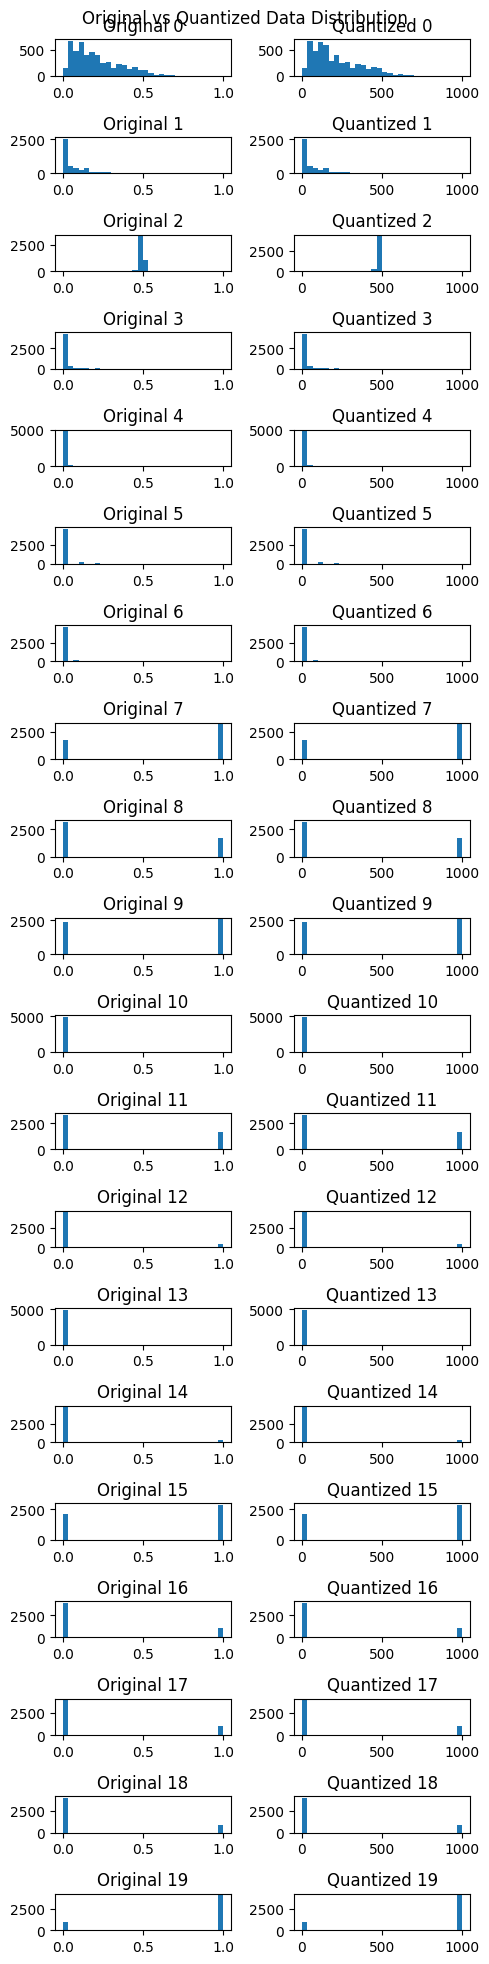

In [ ]:
# test quantizer
# Create a sample dataset
# data = {
#     'A': np.random.uniform(0, 10, 100),
#     'B': np.random.normal(5, 2, 100),
#     'C': np.random.exponential(2, 100)
# }
# df = pd.DataFrame(data).to_numpy()
df = X
quantizer = QuantizationScheme(num_levels=1000, db=df)

# Quantize the dataset
# Option 1: Use the same number of levels for all columns
quantized_df = quantizer.quantize(df)

print(df[0:10])
print(quantized_df[0:10])

# Visualize the quantization effect
import matplotlib.pyplot as plt

fig, axes = plt.subplots(df.shape[1], 2, figsize=(5, 20))
fig.suptitle("Original vs Quantized Data Distribution")

for i in range(df.shape[1]):
    # Original data
    axes[i, 0].hist(df[:,i], bins=30)
    axes[i, 0].set_title(f"Original {i}")

    # Quantized data (10 levels)
    axes[i, 1].hist(quantized_df[:,i], bins=30)
    axes[i, 1].set_title(f"Quantized {i}")

plt.tight_layout()
plt.show()

# Experiments

## Effect of quantization on the vanilla scheme

raw_cfs shape=(2202, 11)
raw_x shape=(2532, 11)
accuracies=[0.16666666666666666, 0.5833333333333334, 0.7166666666666667, 0.8333333333333334], quant_accuracies=[1.0, 1.0, 1.0, 1.0]


<BarContainer object of 4 artists>

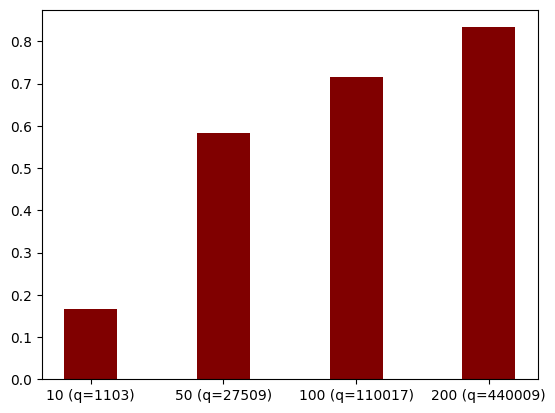

In [ ]:
folder_path = '/content/drive/My Drive//private-cf/test_results'
filename = 'test1.pkl'

# number of runs
n_runs = 1
n_features = 11

# complete list of counterfactuals (unquantized) to sample the databases from
raw_cfs = unique_vectors(X[y==1][:,0:n_features])
print(f'raw_cfs shape={raw_cfs.shape}')

# complete list of query points (unquantized) to sample the queries from
raw_x = X[y==0][:,0:n_features]
print(f'raw_x shape={raw_x.shape}')

num_q_levels_list = [10, 50, 100, 200]
field_sizes = [next_prime(r**2*n_features) for r in num_q_levels_list]

# list of different quantization schemes
quantize_list = [QuantizationScheme(num_levels=n, db=X[:,0:n_features]).quantize for n in num_q_levels_list]

# database and query sizes
db_size = 1000
n_x = 60


# create a dictionary to store results
results_dict = {}
acc_results_dict = {}
n_quantize = len(quantize_list)
for j in range(n_quantize):
  results_dict[j] = {'q_x':[], 'q_db':[], 'cf_ids':[]}
  acc_results_dict[j] = []
results_dict[n_quantize] = {'x':[], 'db':[], 'cf_ids':[]}
acc_results_dict['x'] = []
acc_results_dict['raw_cf'] = []

acc2 = []
# run the experiment
for i in range(n_runs):
  # sample the database and queries
  db = draw_samples(raw_cfs, db_size)
  x = draw_samples(raw_x, n_x)

  # find and store actual unquantized counterfactuals
  cfs, _, cf_ids = find_closest_cfs(db, x)
  results_dict[n_quantize]['x'].extend(x)
  results_dict[n_quantize]['db'].extend(db)
  results_dict[n_quantize]['cf_ids'].extend(cf_ids)

  acc_results_dict['x'].extend(x)
  acc_results_dict['raw_cf'].extend(cfs)

  # for each quantization scheme, retrieve and store counterfactuals
  for j, quantize in enumerate(quantize_list):
    q_db = quantize(db)
    q_x = quantize(x)
    scheme = RetrievalSchemeVanilla(q_db, field_sizes[j], n_features)
    scheme_out = scheme.get_closest_cf_ids(q_x)
    q_cf_ids = scheme_out[0]
    additional_info = scheme_out[1]
    results_dict[j]['q_x'].extend(q_x)
    results_dict[j]['q_db'].extend(q_db)
    results_dict[j]['cf_ids'].extend(q_cf_ids)

    acc_results_dict[j].extend(db[q_cf_ids])

    acc2.append(compute_cf_accuracy(q_x, q_db[q_cf_ids], find_closest_cfs(q_db, q_x)[0]))


save_data(results_dict, folder_path, filename)

# compute accuracies
accuracies = []
for j, quantize in enumerate(quantize_list):
  accuracies.append(compute_cf_accuracy(acc_results_dict['x'], np.array(acc_results_dict[j]), np.array(acc_results_dict['raw_cf'])))

print(f'accuracies={accuracies}, quant_accuracies={acc2}')
plt.bar([f'{n_l} (q={field_sizes[i]})' for i, n_l in enumerate(num_q_levels_list)], accuracies, color ='maroon', width = 0.4)


## Effect of d_min and field size on masked scheme

In [ ]:
# number of runs
n_runs = 100
n_features = 11

# complete list of counterfactuals (unquantized) to sample the databases from
raw_cfs = unique_vectors(X[y==1][:,0:n_features])
print(f'raw_cfs shape={raw_cfs.shape}')

# complete list of query points (unquantized) to sample the queries from
raw_x = X[y==0][:,0:n_features]
print(f'raw_x shape={raw_x.shape}')

# list of different quantization schemes
num_q_levels_list = [20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 300]
field_sizes = [next_prime(r**2*n_features) for r in num_q_levels_list]
quantize_list = [QuantizationScheme(num_levels=n, db=X[:,0:n_features]).quantize for n in num_q_levels_list]

# list of d_mins
d_mins = [1, 5, 10, 20, 50]

# database and query sizes
db_size = 500
n_x = 50


# create a arrays to store accuracies
n_q_schemes = len(quantize_list)
n_d_mins = len(d_mins)
accuracies = np.zeros((n_d_mins, n_q_schemes))
quant_accuracies = np.zeros((n_d_mins, n_q_schemes))

# run the experiment
for i in range(n_runs):
  # sample the database and queries
  db = draw_samples(raw_cfs, db_size)
  x = draw_samples(raw_x, n_x)

  # find actual unquantized counterfactuals
  cfs, _, cf_ids = find_closest_cfs(db, x)

  # iterate over each retrieval scheme
  for s in range(n_d_mins):
    acc = []
    q_acc = []
    # iterate over each quantization scheme
    for q in range(n_q_schemes):
      # retrieve quantiazed counterfactual ids
      quantize = quantize_list[q]
      q_db = quantize(db)
      q_x = quantize(x)
      scheme = RetrievalSchemeMasked(db=q_db, q=field_sizes[q], d=n_features, d_min=d_mins[s])
      scheme_out = scheme.get_closest_cf_ids(q_x)
      q_cf_ids = scheme_out[0]
      additional_info = scheme_out[1]

      # compute and record accuracies
      accuracies[s, q] += compute_cf_accuracy(x, db[q_cf_ids], cfs)
      quant_accuracies[s, q] += compute_cf_accuracy(q_x, q_db[q_cf_ids], find_closest_cfs(q_db, q_x)[0])

  # normalize accuracies
accuracies /= n_runs
quant_accuracies /= n_runs

# print accuracies
print(f'accuracies={accuracies}')
print(f'quant_accuracies={quant_accuracies}')

raw_cfs shape=(2202, 11)
raw_x shape=(2532, 11)


KeyboardInterrupt: 

In [ ]:
accuracies=np.array([
    [0.6392, 0.8114, 0.8756, 0.8984, 0.913, 0.9224, 0.9434, 0.9486, 0.9602, 0.958, 0.966,0.9662, 0.976, 0.9722, 0.9724],
 [0.5058, 0.7776, 0.865, 0.8944, 0.9116, 0.9228, 0.942, 0.9482, 0.9594, 0.9574, 0.9666, 0.9682, 0.9758, 0.971, 0.9726],
  [0.3706, 0.72, 0.8356, 0.8802, 0.9032, 0.9204, 0.936, 0.949, 0.9598, 0.9586, 0.9666, 0.9656, 0.9748, 0.9724, 0.9726],
   [0.2102, 0.589, 0.773, 0.8396, 0.8748, 0.9114, 0.9306, 0.9408, 0.9506, 0.9558, 0.9594, 0.9622, 0.972, 0.9692, 0.9718],
    [0.07, 0.3466, 0.5806, 0.7204, 0.7962, 0.8594, 0.888, 0.912, 0.9252, 0.9346, 0.9468, 0.9504, 0.9608, 0.9616, 0.9684]
    ])

In [ ]:
for s in range(n_d_mins):
  plt.plot(num_q_levels_list, accuracies[s,:], '-o', label=f'd_min={d_mins[s]}' if d_mins[s]>1 else 'no masking')
plt.xlabel('Number of quantization levels')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

## Information leakage

In [ ]:
# number of runs
n_runs = 100
n_features = 2

# complete list of counterfactuals (unquantized) to sample the databases from
raw_cfs = unique_vectors(X[y==1][:,0:n_features])
print(f'raw_cfs shape={raw_cfs.shape}')

# complete list of query points (unquantized) to sample the queries from
raw_x = X[y==0][:,0:n_features]
print(f'raw_x shape={raw_x.shape}')

# list of different quantization schemes
num_q_levels = 5
field_size = next_prime(num_q_levels**2*n_features)
quant_scheme = QuantizationScheme(num_levels=num_q_levels, db=X[:,0:n_features])

# database and query sizes
db_size = 5
n_x = 150

# create a arrays to store results
databases = [] # dim = (n_runs x n_x, M x d)
additional_infos = [] # dim = (n_runs x n_x, t) e.g.: all the norms2 ||y-x||^2
queries = [] # dim = (n_runs x n_x, d)
accuracy = 0
quant_accuracy = 0

# run the experiment
for i in range(n_runs):
  # sample the database and queries
  db = draw_samples(raw_cfs, db_size)
  x = draw_samples(raw_x, n_x)

  # find actual unquantized counterfactuals
  cfs, _, cf_ids = find_closest_cfs(db, x)

  # retrieve quantiazed counterfactual ids
  q_db = quant_scheme.quantize(db)
  q_x = quant_scheme.quantize(x)
  scheme = RetrievalSchemeMasked(db=q_db, q=field_size, d=n_features, d_min=1)
  scheme_out = scheme.get_closest_cf_ids(q_x)
  q_cf_ids = scheme_out[0]
  add_info = scheme_out[1]

  # store results
  databases.extend(np.repeat(q_db.flatten().reshape(1,-1), n_x, axis=0).tolist())
  queries.extend(q_x.tolist())
  additional_infos.extend(add_info.tolist())

  # compute and record accuracies
  accuracy += compute_cf_accuracy(x, db[q_cf_ids], cfs)
  quant_accuracy += compute_cf_accuracy(q_x, q_db[q_cf_ids], find_closest_cfs(q_db, q_x)[0])

databases = np.array(databases)
queries = np.array(queries)
additional_infos = np.array(additional_infos)

# normalize accuracies
accuracy /= n_runs
quant_accuracy /= n_runs
cond_mi = cmidd(databases.tolist(), additional_infos.tolist(), queries.tolist(), base=num_q_levels)

# print accuracies
print(f'accuracy={accuracy}')
print(f'quant_accuracy={quant_accuracy}')
# print(f'cond_mi={cond_mi}, shuffled_cond_mi={shuffle_test(cmidd, databases.tolist(), additional_infos.tolist(), queries.tolist(), ns=100)}')
print(f'cond_mi={cond_mi}')


raw_cfs shape=(628, 2)
raw_x shape=(2532, 2)
accuracy=0.5653999999999997
quant_accuracy=1.0
cond_mi=2.785020365852997


In [ ]:
[5]*3

## Information leakage -- synthetic -- masking

In [ ]:
# import itertools
# import scipy as sp
# from scipy.special import factorial, loggamma

# R = 2
# d = 2
# M = 3

# d_min_range = 3

# q = next_prime(R**2 * d)

# alphabet = range(R+1)
# all_ys = np.array(list(itertools.product(alphabet, repeat=d)))
# all_xs = all_ys.copy()

# c_entropies, mis = [], []
# for d_min in range(1,d_min_range):
#   # print(f'd_min={d_min}')
#   norm_cpmf = []
#   for i, x in enumerate(all_xs):
#     all_ysbutx = np.delete(all_ys, i, axis=0)
#     pmf = {}
#     norms = (np.sum((all_ysbutx-x)**2, axis=1)) % q

#     noisy_norms = []
#     for noise in range(d_min):
#       noisy_norms.extend(((norms + noise) % q).tolist())

#     noisy_norms = np.array(noisy_norms)
#     # print(f'x={x}, noisy_norms={noisy_norms}')

#     for combination in itertools.permutations(noisy_norms, M):
#       # print(combination)
#       if combination in pmf.keys():
#         pmf[combination] += 1
#       else:
#         pmf[combination] = 1
#     pmf = np.array(list(pmf.values()))
#     pmf = pmf.flatten()
#     pmf = pmf[pmf>0]
#     norm_cpmf.extend(pmf.tolist())
#     # print(f'x={x}, pmf={pmf}')

#   n = (R+1)**d
#   p_x = 1 / n
#   p_ytuple = 1 / nPr_log(n-1, M)
#   p_mutuple = 1 / d_min**M

#   c_entropy = -np.sum([p * np.log(p*p_ytuple*p_mutuple) for p in norm_cpmf]) * p_x * p_ytuple * p_mutuple
#   # c_entropy = c_entropy/(np.log(q))
#   c_entropies.append(c_entropy)
#   # mis.append(c_entropy - M * np.log(d_min)/np.log(q))
#   mis.append(c_entropy - M * np.log(d_min))

In [19]:
# AISTATS REBUTTAL

# import itertools
# import scipy as sp
# from scipy.special import factorial, loggamma

# R = 3
# d = 3
# M = 3

# d_min_range = 2  # d_min \in [1:d_min_range-1]

# L = R**2*d+1
# q = next_prime(R**2 * d * L)
# # q = next_prime(R**2 * d)

# if d_min_range - 1 > q:
#   print(f'WARNING: d_min might exceed q. q={q}, d_min_range={d_min_range}')

# alphabet = range(R+1)
# all_ys = np.array(list(itertools.product(alphabet, repeat=d)))
# all_xs = all_ys.copy()


# print(f'R={R} d={d} M={M} q={q} d_min_range={d_min_range} n_ys={len(all_ys)-1}')

# c_entropies, mis = [], []
# for d_min in range(1,d_min_range):
#   print(f'd_min={d_min}')
#   norm_cpmf = []
#   norm_cpmf_dmu = []
#   for i, x in enumerate(all_xs):
#     all_ysbutx = np.delete(all_ys, i, axis=0)
#     pmf = {}
#     norms = (np.sum((all_ysbutx-x)**2, axis=1)) % q

#     for db_combination in itertools.permutations(norms, M):
#       db_combination = np.array(db_combination)
#       noisy_norms = []
#       pmf_dmu = {}
#       for mu_combination in itertools.product(range(d_min), repeat=M):
#         mu_combination = np.array(mu_combination)
#         # print(f'db_combination={db_combination}, mu_combination={mu_combination}, noisy_norms={(db_combination + mu_combination) % q}')
#         noisy_combination = (db_combination + mu_combination) % q
#         noisy_norms.extend(noisy_combination.tolist())

#         for noisy_norm in noisy_combination:
#           if noisy_norm in pmf_dmu.keys():
#             pmf_dmu[noisy_norm] += 1
#           else:
#             pmf_dmu[noisy_norm] = 1

#       noisy_norms = np.array(noisy_norms)


#       for noisy_norm in noisy_norms:
#         if noisy_norm in pmf.keys():
#           pmf[noisy_norm] += 1
#         else:
#           pmf[noisy_norm] = 1
#     pmf = np.array(list(pmf.values()))
#     pmf = pmf.flatten()
#     pmf = pmf[pmf>0]
#     norm_cpmf.extend(pmf.tolist())
#     # print(f'x={x}, pmf={pmf}')

#   n = (R+1)**d
#   p_x = 1 / n
#   p_ytuple = 1 / nPr_log(n-1, M)
#   p_mutuple = 1 / d_min**M

#   # c_entropy = -np.sum([p * np.log(p*p_ytuple*p_mutuple) for p in norm_cpmf]) * p_x * p_ytuple * p_mutuple
#   c_entropy = -np.sum([p * np.log(p*p_ytuple) for p in norm_cpmf]) * p_x * p_ytuple
#   c_entropy = c_entropy/(np.log(q))
#   c_entropies.append(float(c_entropy))
#   mis.append(float(c_entropy - M * np.log(d_min)/np.log(q)))
#   print(f'leakages={mis}')
#   print(f'cross entropies={c_entropies}')

R=3 d=3 M=3 q=757 d_min_range=2 n_ys=63
d_min=1
leakages=[0.6470852052466715]
cross entropies=[0.6470852052466715]


In [32]:
import itertools
import scipy as sp
from scipy.special import factorial, loggamma

R = 3
d = 3
M = 3

d_min_range = 4  # d_min \in [1:d_min_range-1]

L = R**2*d+1
q = next_prime(R**2 * d * L)
# q = next_prime(R**2 * d)

if d_min_range - 1 > q:
  print(f'WARNING: d_min might exceed q. q={q}, d_min_range={d_min_range}')

alphabet = range(R+1)
all_ys = np.array(list(itertools.product(alphabet, repeat=d)))
all_xs = all_ys.copy()


print(f'R={R} d={d} M={M} q={q} d_min_range={d_min_range} n_ys={len(all_ys)-1}')

c_entropies, mis = [], []
for d_min in range(1,d_min_range):
    print(f'd_min={d_min}')
    counts = []
    for i, x in enumerate(all_xs):
        all_ysbutx = np.delete(all_ys, i, axis=0)
        norms = (np.sum((all_ysbutx-x)**2, axis=1)) % q
        counts_x = {}
        for db_combination in itertools.permutations(norms, M):
            db_combination = np.array(db_combination)
            for mu_combination in itertools.product(range(d_min), repeat=M):
                mu_combination = np.array(mu_combination)
                noisy_combination = tuple((db_combination + mu_combination) % q)
                
                if noisy_combination in counts_x.keys():
                    counts_x[noisy_combination] += 1
                else:
                    counts_x[noisy_combination] = 1
        counts.extend(list(counts_x.values()))

    n = (R+1)**d
    p_x = 1 / n
    p_ytuple = 1 / nPr_log(n-1, M)
    p_mutuple = 1 / d_min**M

    c_entropy = -p_x * p_ytuple * p_mutuple * np.sum([count * np.log(p_ytuple * p_mutuple * count) for count in counts])
    c_entropy = c_entropy/(np.log(q))
    c_entropies.append(float(c_entropy))
    mis.append(float(c_entropy - M * np.log(d_min)/np.log(q)))
print(f'leakages={mis}')
print(f'cross entropies={c_entropies}')

R=3 d=3 M=3 q=757 d_min_range=4 n_ys=63
d_min=1
d_min=2
d_min=3
leakages=[1.1432079195580418, 0.9109976913917002, 0.777310689023055]
cross entropies=[1.1432079195580418, 1.2246690746277307, 1.274468069001498]


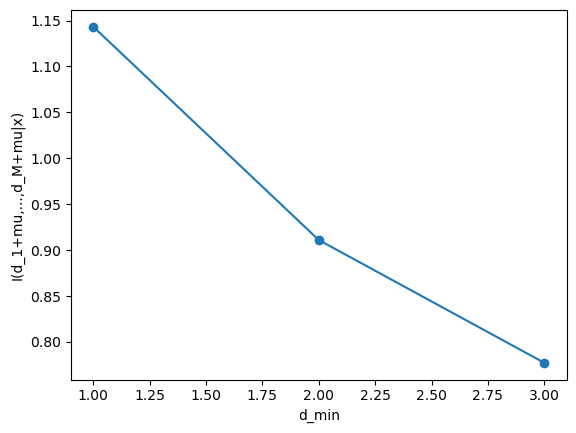

In [34]:
plt.plot(range(1,d_min_range), mis, '-o')
plt.xlabel('d_min')
plt.ylabel('I(d_1+mu,...,d_M+mu|x)')
plt.show()
#plt.plot(range(1,d_min_range), c_entropies)

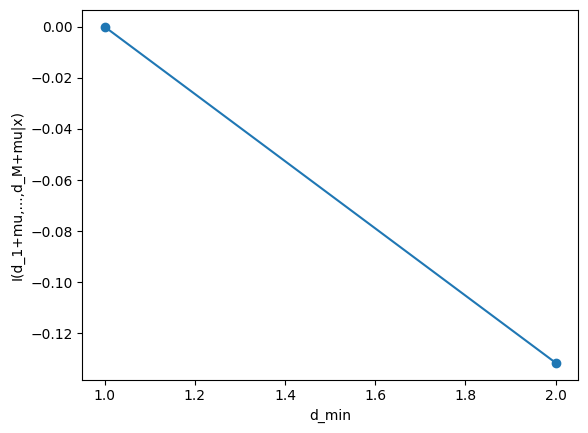

In [ ]:
import itertools
import scipy as sp
from scipy.special import factorial, loggamma

R = 3
d = 3
M = 3

d_min_range = 3


q = next_prime(R**2 * d)

alphabet = range(R+1)
all_ys = np.array(list(itertools.product(alphabet, repeat=d)))
all_xs = all_ys.copy()

c_entropies, mis = [], []
for d_min in range(1,d_min_range):
  # print(f'd_min={d_min}')
  norm_cpmf = []
  for i, x in enumerate(all_xs):
    all_ysbutx = np.delete(all_ys, i, axis=0)
    pmf = {}
    norms = (np.sum((all_ysbutx-x)**2, axis=1)) % q

    noisy_norms = []
    for noise in range(1,d_min):
      noisy_norms.extend(((norms + noise) % q).tolist())

    noisy_norms = np.array(noisy_norms)
    # print(f'x={x}, noisy_norms={noisy_norms}')

    for combination in itertools.permutations(noisy_norms, M):

      if combination in pmf.keys():
        pmf[combination] += 1
      else:
        pmf[combination] = 1
    pmf = np.array(list(pmf.values()))
    pmf = pmf.flatten()
    pmf = pmf[pmf>0]
    norm_cpmf.extend(pmf.tolist())
    # print(f'x={x}, pmf={pmf}')

  n = (R+1)**d
  p_x = 1 / n
  p_ytuple = 1 / nPr_log(n-1, M)
  p_mutuple = 1 / d_min**M
  c_entropy = -np.sum([p * np.log(p*p_ytuple*p_mutuple) for p in norm_cpmf]) * p_x * p_ytuple * p_mutuple
  c_entropy = c_entropy/(np.log(q))
  c_entropies.append(c_entropy)
  mis.append(c_entropy - (M * np.log(d_min)/np.log(q)))
plt.plot(range(1,d_min_range), mis, '-o')
plt.xlabel('d_min')
plt.ylabel('I(d_1+mu,...,d_M+mu|x)')
plt.show()

## Information leakage -- synthetic -- vanilla & diff

In [ ]:
# R = 3
# d = 3
# M = 3
# scheme = 'diff'    # 'vanilla' for vanilla, 'diff' for difference

# # q = next_prime(R**2 * d)
# L = R**2*d+1
# q = next_prime(R**2 * d * L)

# alphabet = range(R+1)
# all_ys = np.array(list(itertools.product(alphabet, repeat=d)))
# all_xs = all_ys.copy()

# print(f'R={R} d={d} M={M} q={q} scheme={scheme} n_ys={len(all_ys)-1}')

# # print(f'd_min={d_min}')
# norm_cpmf = []
# for i, x in enumerate(all_xs):
#   all_ysbutx = np.delete(all_ys, i, axis=0)
#   pmf = {}

#   norms = (np.sum((all_ysbutx-x)**2, axis=1)) % q
#   if scheme == 'vanilla':
#     norm_diffs = norms
#   elif scheme == 'diff':
#     norm_diffs = np.array([norms[i+1]-norms[i] for i in range(len(norms)-1)])

#   for combination in itertools.permutations(norm_diffs, M):
#     # print(combination)
#     if combination in pmf.keys():
#       pmf[combination] += 1
#     else:
#       pmf[combination] = 1
#   pmf = np.array(list(pmf.values()))
#   pmf = pmf.flatten()
#   pmf = pmf[pmf>0]
#   norm_cpmf.extend(pmf.tolist())
#   # print(f'x={x}, pmf={pmf}')

# n = (R+1)**d
# p_x = 1 / n
# p_ytuple = 1 / nPr_log(n-1, M)

# c_entropy = -np.sum([p * np.log(p*p_ytuple) for p in norm_cpmf]) * p_x * p_ytuple
# c_entropy = c_entropy/(np.log(q))
# m_info = c_entropy

# print(f'mutual information={m_info}')

In [31]:
# Corrected after AISTATS submission

R = 3
d = 3
M = 3
scheme = 'vanilla'    # 'vanilla' for vanilla, 'diff' for difference

# q = next_prime(R**2 * d)
L = R**2*d+1
q = next_prime(R**2 * d * L)

alphabet = range(R+1)
all_ys = np.array(list(itertools.product(alphabet, repeat=d)))
all_xs = all_ys.copy()

print(f'R={R} d={d} M={M} q={q} scheme={scheme} n_ys={len(all_ys)-1}')

# print(f'd_min={d_min}')
norm_cpmf = []
for i, x in enumerate(all_xs):
  all_ysbutx = np.delete(all_ys, i, axis=0)
  pmf = {}

  norms = (np.sum((all_ysbutx-x)**2, axis=1)) % q
  for combination in itertools.permutations(norms, M):
    if scheme == 'vanilla':
        combination = combination
    elif scheme == 'diff':
        combination = tuple([combination[i+1]-combination[i] for i in range(len(combination)-1)])

    if combination in pmf.keys():
      pmf[combination] += 1
    else:
      pmf[combination] = 1
  pmf = np.array(list(pmf.values()))
  pmf = pmf.flatten()
  pmf = pmf[pmf>0]
  norm_cpmf.extend(pmf.tolist())
  # print(f'x={x}, pmf={pmf}')

n = (R+1)**d
p_x = 1 / n
p_ytuple = 1 / nPr_log(n-1, M)

c_entropy = -np.sum([p * np.log(p*p_ytuple) for p in norm_cpmf]) * p_x * p_ytuple
c_entropy = c_entropy/(np.log(q))
m_info = c_entropy

print(f'mutual information={m_info}')

R=3 d=3 M=3 q=757 scheme=vanilla n_ys=63
mutual information=1.1432079195580418


In [ ]:
# vanilla old method:
1.1432079195580418

# vanilla new method
1.1432079195580418

# diff old method
0.7689342466660568

# diff new method
0.9404613898291249

## Information leakage - single-phase immutable

In [ ]:
R = 3
d = 2
M = 3
k = 1

L = R**2*d+1
q = next_prime(R**2 * d * L)

alphabet = range(R+1)
all_ys = np.array(list(itertools.product(alphabet, repeat=d)))
all_xs = all_ys.copy()
all_Is = generate_binary_vectors(length=d, weight=k)

# print(f'd_min={d_min}')
norm_cpmf = []
for the_I in all_Is:
  W = np.diag(the_I*(L-1)+1)
  for i, x in enumerate(all_xs):
    all_ysbutx = np.delete(all_ys, i, axis=0)
    pmf = {}

    norms = ((all_ysbutx-x) @ W @ (all_ysbutx-x).T) % q
    norm_diffs = np.diag(norms)

    for combination in itertools.permutations(norm_diffs, M):
      # print(combination)
      if combination in pmf.keys():
        pmf[combination] += 1
      else:
        pmf[combination] = 1
    pmf = np.array(list(pmf.values()))
    pmf = pmf.flatten()
    pmf = pmf[pmf>0]
    norm_cpmf.extend(pmf.tolist())
  # print(f'x={x}, pmf={pmf}')

n = (R+1)**d
p_x = 1 / n
p_ytuple = 1 / nPr_log(n-1, M)
p_I = 1 / sp.special.binom(d, k)

c_entropy = -np.sum([p * np.log(p*p_ytuple) for p in norm_cpmf]) * p_x * p_ytuple * p_I
c_entropy = c_entropy/(np.log(q))
m_info = c_entropy

print(f'mutual information={m_info}')


mutual information=1.1753531166230147


## Information leakage - two-phase immutable

### with first phase answers -- not working

In [ ]:
folder_path = '/content/drive/My Drive//private-cf/test_results'
filename = 'twophaseleak.pkl'
file_path = os.path.join(folder_path, filename)

R = 3
d = 2
M = 3
k = 1

q = next_prime(R**2 * d)

alphabet = range(R+1)
all_ys = np.array(list(itertools.product(alphabet, repeat=d)))
all_xs = all_ys.copy()
all_Is = generate_binary_vectors(length=d, weight=k)
all_rhos = range(1,q)

x_indxs = range(len(all_xs))
I_indxs = range(len(all_Is))

pmf = {}
start_time = time.time()
for I_indx in I_indxs:
  the_I = all_Is[I_indx].astype(bool)
  the_M = (1 - the_I).astype(bool)
  for x_indx in x_indxs:
    x = all_xs[x_indx]
    all_ysbutx = np.delete(all_ys, x_indx, axis=0)
    for rhos in itertools.permutations(all_rhos, M):
      for db_indxs in itertools.combinations(range(len(all_ysbutx)), M):
        db = all_ysbutx[list(db_indxs)]
        e = np.all(x[the_I]==db[:,the_I], axis=1).astype(int)
        A_M = tuple([np.linalg.norm(db[i,the_M]*e[i]-x[the_M])**2 for i in range(len(db))])
        A_I = tuple([rhos[i]*np.linalg.norm(db[i,the_I]-x[the_I])**2 for i in range(len(db))])
        key = (I_indx, x_indx, rhos, tuple(e), A_M, A_I)
        if key in pmf.keys():
          pmf[key] += 1
        else:
          pmf[key] = 1
runtime = time.time() - start_time
print(f'runtime={runtime}')
with open(file_path, 'wb') as handle:
    pickle.dump(pmf, handle)
    pickle.dump(runtime, handle)

#c_entropy = -np.sum([p * np.log(p*p_ytuple) for p in norm_cpmf]) * p_x * p_ytuple * p_I
#c_entropy = c_entropy/(np.log(q))
#m_info = c_entropy

#print(f'mutual information={m_info}')

In [ ]:
folder_path = '/content/drive/My Drive//private-cf/test_results'
filename = 'twophaseleak.pkl'
file_path = os.path.join(folder_path, filename)

with open(file_path, 'rb') as handle:
    a = pickle.load(handle)
    b = pickle.load(handle)


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/My Drive//private-cf/test_results/twophaseleak.pkl'

### without first phase answers

In [ ]:
def get_marginals(pmf, targets):
  marginal_pmf = {}
  for key in pmf.keys():
    mpmf_key = tuple([key[i] for i in targets])
    if mpmf_key in marginal_pmf.keys():
      marginal_pmf[mpmf_key] += pmf[key]
    else:
      marginal_pmf[mpmf_key] = pmf[key]

  return marginal_pmf

def compute_entropy(pmf, targets, conditions):
  all_rvs = targets + conditions
  joint_pmf = get_marginals(pmf, all_rvs)
  cmarginal_pmf = get_marginals(pmf, conditions)

  condit_pmf = {}
  for key in joint_pmf.keys():
    cmpmf_key = tuple([key[i+len(targets)] for i in range(len(conditions))])
    condit_pmf[key] = joint_pmf[key] / cmarginal_pmf[cmpmf_key]

  entropy = -np.sum([jpmf * np.log(cpmf) for jpmf, cpmf in zip(joint_pmf.values(), condit_pmf.values())])
  return entropy


In [ ]:
folder_path = '/content/drive/My Drive//private-cf/test_results'
filename = 'twophaseleak.pkl'
file_path = os.path.join(folder_path, filename)

R = 3
d = 2
M = 3
k = 1

L = R**2*d+1
q = next_prime(R**2 * d * L)
# q = next_prime(R**2 * d)

alphabet = range(R+1)
all_ys = np.array(list(itertools.product(alphabet, repeat=d)))
all_xs = all_ys.copy()
all_Is = generate_binary_vectors(length=d, weight=k)

x_indxs = range(len(all_xs))
I_indxs = range(len(all_Is))

pmf = {} # pmf key format: (I, X, E, A_M)
start_time = time.time()
for I_indx in I_indxs:
  the_I = all_Is[I_indx].astype(bool)
  the_M = (1 - the_I).astype(bool)
  for x_indx in x_indxs:
    x = all_xs[x_indx]
    all_ysbutx = np.delete(all_ys, x_indx, axis=0)
    for db_indxs in itertools.combinations(range(len(all_ysbutx)), M):
      db = all_ysbutx[list(db_indxs)]
      e = tuple(np.all(x[the_I]==db[:,the_I], axis=1).astype(int))
      A_M = tuple([int(np.linalg.norm(db[i,the_M]*e[i]-x[the_M])**2 % q) for i in range(len(db))])
      key = (I_indx, x_indx, e, A_M)
      if key in pmf.keys():
        pmf[key] += 1
      else:
        pmf[key] = 1

factor = 1.0 / np.sum(list(pmf.values()))
pmf = {key: value * factor for key, value in pmf.items()}

# save the pmf
runtime = time.time() - start_time
# print(f'runtime={runtime}')
with open(file_path, 'wb') as handle:
    pickle.dump(pmf, handle)
    pickle.dump(runtime, handle)

# compute entropies
m_info = (compute_entropy(pmf, [2], [0,1]) + compute_entropy(pmf, [3], [0,1,2])) / np.log(q)
print(f'mutual information={m_info}')

mutual information=0.29100525641406394


In [ ]:
# test entropy computation
jp = [6/20, 3/20, 2/20, 7/20, 2/20]
cp = [6/13, 3/3, 2/2, 7/13, 2/2]
print(-np.sum([jp[i]*np.log(cp[i]) for i in range(len(jp))]) / np.log(q))

test_pmf = {
    (0, (0,0), 1): 6,
    (0, (1,0), 0): 3,
    (1, (0,1), 0): 2,
    (1, (0,0), 1): 7,
    (0, (1,1), 0): 2,
}
factor = 1.0 / np.sum(list(test_pmf.values()))
test_pmf = {key: value * factor for key, value in test_pmf.items()}

print(compute_entropy(test_pmf, [0], [1, 2]) / np.log(q))

0.07669614977616244
0.07669614977616246


## Information leakage - real data - vanilla and diff

In [ ]:
R = 3
d = X.shape[1]
M = 10
scheme = 'diff'    # 'vanilla' for vanilla, 'diff' for difference
n_runs = 3

# q = next_prime(R**2 * d)
L = R**2*d+1
q = next_prime(R**2 * d * L)

quantize = QuantizationScheme(num_levels=R+1, db=X).quantize
X_quantized = quantize(X)
unique_ids = unique_row_ids(X_quantized)

X_quantized = X_quantized[unique_ids]
y_quantized = y[unique_ids]

X_accepted = X_quantized[y_quantized==1]
X_rejected = X_quantized[y_quantized==0]

print(f'R={R} d={d} M={M} q={q} scheme={scheme} len_X_accepted={len(X_accepted)} len_X_rejected={len(X_rejected)}')

# print(f'd_min={d_min}')
norm_cpmf = []
for x_id in range(len(X_rejected)):
  x = X_rejected[x_id, :]
  cfs = X_accepted

  pmf = {}
  norms = (np.sum((cfs-x)**2, axis=1)) % q
  
  for combination in itertools.permutations(norms, M):
    if scheme == 'vanilla':
      combination = combination
    elif scheme == 'diff':
      combination = tuple([combination[i+1]-combination[i] for i in range(len(combination)-1)])
    
    if combination in pmf.keys():
      pmf[combination] += 1
    else:
      pmf[combination] = 1
  pmf = np.array(list(pmf.values()))
  pmf = pmf.flatten()
  pmf = pmf[pmf>0]
  norm_cpmf.extend(pmf.tolist())
  # print(f'x={x}, pmf={pmf}')

n = (R+1)**d
p_x = 1 / len(X_rejected)
p_ytuple = 1 / nPr_log(len(X_accepted), M)

c_entropy = -np.sum([p * np.log(p*p_ytuple) for p in norm_cpmf]) * p_x * p_ytuple
c_entropy = c_entropy/(np.log(q))
m_info = c_entropy

print(f'mutual information={m_info}')

R=3 d=20 M=10 q=32587 scheme=diff len_X_accepted=129 len_X_rejected=107


In [ ]:
R=3 d=20 M=3 q=32587 scheme=vanilla len_X_accepted=129 len_X_rejected=107
mutual information=0.8417868167228717

## Runtime - schemes with immutable features

In [ ]:
len(unique_vectors(X[y==1][:,0:5]))

1891

In [ ]:
folder_path = '/content/drive/My Drive//private-cf/test_results'
filename = 'immutable_runtimes.pkl'

runtimes_dict = {}


db_size_list = [10, 20, 50, 100, 200, 500, 1000]
n_features_list = [5, 10, 15, 20]

for db_size in db_size_list:
  for n_features in n_features_list:
    # parameters
    n_runs = 100
    # n_features = 20
    # db_size = 1000
    n_x = 1
    n_immutables = 3
    n_quant_levels = 5

    # complete list of counterfactuals (unquantized) to sample the databases from
    raw_cfs = unique_vectors(X[y==1][:,0:n_features])
    print(f'raw_cfs shape={raw_cfs.shape}')

    # complete list of query points (unquantized) to sample the queries from
    raw_x = X[y==0][:,0:n_features]
    print(f'raw_x shape={raw_x.shape}')

    L = n_quant_levels**2*n_features + 1
    field_size = next_prime(n_quant_levels**2*L*n_features)

    # list of different quantization schemes
    quant_scheme = QuantizationScheme(num_levels=n_quant_levels, db=X[:,0:n_features]).quantize

    # create a dictionary to store results


    print(f'q={field_size}, L={L}, d={n_features}')

    times1, times2 = [], []
    # run the experiment
    for run_i in range(n_runs):
      # sample the database and queries
      db = draw_samples(raw_cfs, db_size)
      x = draw_samples(raw_x, n_x)
      h = np.concatenate([np.ones((len(x),n_immutables)), np.zeros((len(x), n_features-n_immutables))], axis=1)
      [np.random.shuffle(h_row) for h_row in h]

      # initialize schemes
      q_db = quant_scheme(db)
      q_x = quant_scheme(x)
      scheme1 = RetrievalSchemeSinglePhaseImmutable(q_db, field_size, n_features, L)
      scheme2 = RetrievalSchemeTwoPhaseImmutable(q_db, field_size, n_features)

      # retrieve single-phase counterfactuals
      s1_start_time = time.time()
      cfs1 = scheme1.get_closest_cf_ids(q_x, h*(L-1)+1)[0]
      s1_duration = time.time() - s1_start_time
      times1.append(s1_duration / n_x)

      # retrieve two-phase counterfactuals
      s2_start_time = time.time()
      cfs2 = scheme2.get_closest_cf_ids(q_x, h)[0]
      s2_duration = time.time() - s2_start_time
      times2.append(s2_duration / n_x)

      # retrieve exact counterfactuals
      cfs_exact = find_closest_cfs_with_immutables(q_db, q_x, h)[2]

      # compute accuracies
      try:
        cfs1_valid = cfs1[cfs1 != None].astype(int)
        cfs2_valid = cfs2[cfs2 != None].astype(int)
        cfse_valid = cfs_exact[cfs_exact != None].astype(int)
        acc1 = compute_cf_accuracy(q_x[cfs1 != None], q_db[cfs1_valid], q_db[cfse_valid])
        acc2 = compute_cf_accuracy(q_x[cfs2 != None], q_db[cfs2_valid], q_db[cfse_valid])
        print(f'run_i={run_i}, acc1={acc1}, acc2={acc2}', 'WARNING!! Innacurate retrieval' if ( acc1 < 1 or acc2 < 1) else '')
      except Exception as e:
        print(f'error in accuracy computation: {e}')

    times1_avg = np.average(times1)
    times1_std = np.std(times1)
    times2_avg = np.average(times2)
    times2_std = np.std(times2)
    print(f'times1={times1_avg}, times2={times2_avg}')

    runtimes_dict[(db_size, n_features, n_immutables)] = {'scheme1_avg': times1_avg,
                                                          'scheme2_avg': times2_avg,
                                                          'scheme1_std': times1_std,
                                                          'scheme2_std': times2_std}

    save_data(runtimes_dict, folder_path, filename)

raw_cfs shape=(1891, 5)
raw_x shape=(2532, 5)
q=15761, L=126, d=5
run_i=0, acc1=1.0, acc2=1.0 
run_i=1, acc1=1.0, acc2=1.0 
run_i=2, acc1=1.0, acc2=1.0 
run_i=3, acc1=1.0, acc2=1.0 
run_i=4, acc1=1.0, acc2=1.0 
run_i=5, acc1=1.0, acc2=1.0 
run_i=6, acc1=1.0, acc2=1.0 
run_i=7, acc1=1.0, acc2=1.0 
run_i=8, acc1=1.0, acc2=1.0 
run_i=9, acc1=1.0, acc2=1.0 
run_i=10, acc1=1.0, acc2=1.0 
run_i=11, acc1=1.0, acc2=1.0 
run_i=12, acc1=1.0, acc2=1.0 
run_i=13, acc1=1.0, acc2=1.0 
run_i=14, acc1=1.0, acc2=1.0 
run_i=15, acc1=1.0, acc2=1.0 
run_i=16, acc1=1.0, acc2=1.0 
run_i=17, acc1=1.0, acc2=1.0 
run_i=18, acc1=1.0, acc2=1.0 
run_i=19, acc1=1.0, acc2=1.0 
run_i=20, acc1=nan, acc2=nan 
run_i=21, acc1=1.0, acc2=1.0 
run_i=22, acc1=1.0, acc2=1.0 
run_i=23, acc1=1.0, acc2=1.0 
run_i=24, acc1=nan, acc2=nan 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


run_i=25, acc1=1.0, acc2=1.0 
run_i=26, acc1=1.0, acc2=1.0 
run_i=27, acc1=1.0, acc2=1.0 
run_i=28, acc1=1.0, acc2=1.0 
run_i=29, acc1=1.0, acc2=1.0 
run_i=30, acc1=1.0, acc2=1.0 
run_i=31, acc1=nan, acc2=nan 
run_i=32, acc1=1.0, acc2=1.0 
run_i=33, acc1=1.0, acc2=1.0 
run_i=34, acc1=nan, acc2=nan 
run_i=35, acc1=1.0, acc2=1.0 
run_i=36, acc1=nan, acc2=nan 
run_i=37, acc1=1.0, acc2=1.0 
run_i=38, acc1=1.0, acc2=1.0 
run_i=39, acc1=nan, acc2=nan 
run_i=40, acc1=1.0, acc2=1.0 
run_i=41, acc1=1.0, acc2=1.0 
run_i=42, acc1=1.0, acc2=1.0 
run_i=43, acc1=1.0, acc2=1.0 
run_i=44, acc1=1.0, acc2=1.0 
run_i=45, acc1=1.0, acc2=1.0 
run_i=46, acc1=1.0, acc2=1.0 
run_i=47, acc1=1.0, acc2=1.0 
run_i=48, acc1=1.0, acc2=1.0 
run_i=49, acc1=1.0, acc2=1.0 
run_i=50, acc1=1.0, acc2=1.0 
run_i=51, acc1=1.0, acc2=1.0 
run_i=52, acc1=1.0, acc2=1.0 
run_i=53, acc1=1.0, acc2=1.0 
run_i=54, acc1=1.0, acc2=1.0 
run_i=55, acc1=1.0, acc2=1.0 
run_i=56, acc1=1.0, acc2=1.0 
run_i=57, acc1=1.0, acc2=1.0 
run_i=58, 

# Other stuff

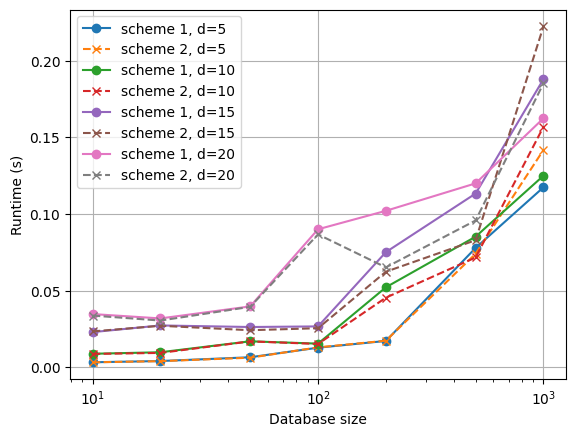

In [ ]:
for n_features in n_features_list:
  plt.plot(db_size_list, [runtimes_dict[(db_size, n_features, 3)]['scheme1_avg'] for db_size in db_size_list], '-o', label=f'scheme 1, d={n_features}')
  plt.plot(db_size_list, [runtimes_dict[(db_size, n_features, 3)]['scheme2_avg'] for db_size in db_size_list], '--x', label=f'scheme 2, d={n_features}')
plt.legend()
plt.xlabel('Database size')
plt.xscale('log')
plt.ylabel('Runtime (s)')
plt.grid(True)
plt.show()

(196, 5)


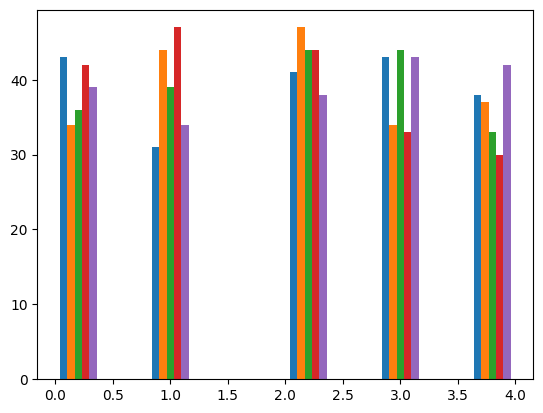

In [ ]:
#############database leakage##############
# scheme_no_masking
# scheme_difference
# scheme_masking
db = unique_vectors(np.random.randint(low=0, high=5, size=(200,5)))
print(db.shape)
plt.hist(db, bins=10)
plt.show()


In [ ]:
a = np.array([[0,1],[1,1]])
b = np.array([[0,2], [2,0]])
c = np.array([100, 1])

print(find_closest_cfs(a, b, c)[0])

[[0 1]
 [1 1]]


In [ ]:
import random
from math import log, pi
import numpy.random as nr
from numpy.linalg import det

# Some test cases to see usage and correctness

# Differential entropy estimator
print(
    "For a uniform distribution with width alpha, the differential entropy is log_2 alpha, setting alpha = 2"
)
print("and using k=1, 2, 3, 4, 5")
print(
    "result:",
    [
        entropy([[2 * random.random()] for i in range(1000)], k=j + 1)
        for j in range(5)
    ],
)

# CONDITIONAL MUTUAL INFORMATION
Ntry = [10, 25, 50, 100, 200]  # , 1000, 2000] #Number of samples to use in estimate
nsamples = 100  # Number of times to est mutual information for CI
samplo = int(0.025 * nsamples)  # confidence intervals
samphi = int(0.975 * nsamples)

print("\nGaussian random variables\n")
print("Conditional Mutual Information")
d1 = [1, 1, 0]
d2 = [1, 0, 1]
d3 = [0, 1, 1]
mat = [d1, d2, d3]
tmat = np.transpose(mat)
diag = [[3, 0, 0], [0, 1, 0], [0, 0, 1]]
mean = np.array([0, 0, 0])
cov = np.dot(tmat, np.dot(diag, mat))
print("covariance matrix")
print(cov)
trueent = -0.5 * (3 + log(8.0 * pi * pi * pi * det(cov)))
trueent += -0.5 * (1 + log(2.0 * pi * cov[2][2]))  # z sub
trueent += 0.5 * (
    2 + log(4.0 * pi * pi * det([[cov[0][0], cov[0][2]], [cov[2][0], cov[2][2]]]))
)  # xz sub
trueent += 0.5 * (
    2 + log(4.0 * pi * pi * det([[cov[1][1], cov[1][2]], [cov[2][1], cov[2][2]]]))
)  # yz sub
print("true CMI(x:y|x)", trueent / log(2))

ent = []
err = []
for NN in Ntry:
    tempent = []
    for j in range(nsamples):
        points = nr.multivariate_normal(mean, cov, NN)
        x = [point[:1] for point in points]
        y = [point[1:2] for point in points]
        z = [point[2:] for point in points]
        tempent.append(cmi(x, y, z))
    tempent.sort()
    tempmean = np.mean(tempent)
    ent.append(tempmean)
    err.append((tempmean - tempent[samplo], tempent[samphi] - tempmean))

print("samples used", Ntry)
print("estimated CMI", ent)
print("95% conf int. (a, b) means (mean - a, mean + b)is interval\n", err)

# MUTUAL INFORMATION

print("Mutual Information")
trueent = 0.5 * (1 + log(2.0 * pi * cov[0][0]))  # x sub
trueent += 0.5 * (1 + log(2.0 * pi * cov[1][1]))  # y sub
trueent += -0.5 * (
    2 + log(4.0 * pi * pi * det([[cov[0][0], cov[0][1]], [cov[1][0], cov[1][1]]]))
)  # xz sub
print("true MI(x:y)", trueent / log(2))

ent = []
err = []
for NN in Ntry:
    tempent = []
    for j in range(nsamples):
        points = nr.multivariate_normal(mean, cov, NN)
        x = [point[:1] for point in points]
        y = [point[1:2] for point in points]
        tempent.append(mi(x, y))
    tempent.sort()
    tempmean = np.mean(tempent)
    ent.append(tempmean)
    err.append((tempmean - tempent[samplo], tempent[samphi] - tempmean))

print("samples used", Ntry)
print("estimated MI", ent)
print("95% conf int.\n", err)


print("\nIF you permute the indices of x, e.g., MI(X:Y) = 0")
# You can use shuffle_test method to just get mean, standard deviation
ent = []
err = []
for NN in Ntry:
    tempent = []
    for j in range(nsamples):
        points = nr.multivariate_normal(mean, cov, NN)
        x = [point[:1] for point in points]
        y = [point[1:2] for point in points]
        random.shuffle(y)
        tempent.append(mi(x, y))
    tempent.sort()
    tempmean = np.mean(tempent)
    ent.append(tempmean)
    err.append((tempmean - tempent[samplo], tempent[samphi] - tempmean))

print("samples used", Ntry)
print("estimated MI", ent)
print("95% conf int.\n", err)

# DISCRETE ESTIMATORS

print("\n\nTest of the discrete entropy estimators\n")
print(
    "For z = y xor x, w/x, y uniform random binary, we should get H(x)=H(y)=H(z) = 1, H(x:y) etc = 0, H(x:y|z) = 1"
)
x = [0, 0, 0, 0, 1, 1, 1, 1]
y = [0, 1, 0, 1, 0, 1, 0, 1]
z = [0, 1, 0, 1, 1, 0, 1, 0]
print("H(x), H(y), H(z)", entropyd(x), entropyd(y), entropyd(z))
print("H(x:y), etc", midd(x, y), midd(z, y), midd(x, z))
print("H(x:y|z), etc", cmidd(x, y, z), cmidd(z, y, x), cmidd(x, z, y))


# KL Div estimator
print(
    "\n\nKl divergence estimator (not symmetric, not required to have same num samples in each sample set"
)
print("should be 0 for same distribution")
sample1 = [[2 * random.random()] for i in range(200)]
sample2 = [[2 * random.random()] for i in range(300)]
print("result:", kldiv(sample1, sample2))
print(
    "should be infinite for totally disjoint distributions (but this estimator has an upper bound like log(dist) between disjoint prob. masses)"
)
sample2 = [[3 + 2 * random.random()] for i in range(300)]
print("result:", kldiv(sample1, sample2))


def test_discrete(size=1000, y_func=lambda x: x**2):
    print("\nTest discrete.")
    from collections import defaultdict

    information = defaultdict(list)
    y_entropy = defaultdict(list)
    x_entropy = []
    for trial in range(10):
        x = np.random.randint(low=0, high=10, size=size)

        y_random = np.random.randint(low=53, high=53 + 5, size=size)
        y_deterministic = y_func(x)
        noise = np.random.randint(low=0, high=10, size=size)
        y_noisy = y_deterministic + noise

        information["random"].append(midd(x, y_random))
        information["deterministic"].append(midd(x, y_deterministic))
        information["noisy"].append(midd(x, y_noisy))

        x_entropy.append(entropyd(x))
        y_entropy["random"].append(entropyd(y_random))
        y_entropy["deterministic"].append(entropyd(y_deterministic))
        y_entropy["noisy"].append(entropyd(y_noisy))
    x_entropy = np.mean(x_entropy)
    for experiment_name in information.keys():
        max_information = min(x_entropy, np.mean(y_entropy[experiment_name]))
        print(
            f"{experiment_name}: I(X; Y) = {np.mean(information[experiment_name]):.4f} "
            f"± {np.std(information[experiment_name]):.4f} (maximum possible {max_information:.4f})"
        )


test_discrete()

For a uniform distribution with width alpha, the differential entropy is log_2 alpha, setting alpha = 2
and using k=1, 2, 3, 4, 5
result: [0.9993879886686857, 1.0553127755144776, 1.0167465265081774, 0.9891288217165741, 0.9765116252576572]

Gaussian random variables

Conditional Mutual Information
covariance matrix
[[4 3 1]
 [3 4 1]
 [1 1 2]]
true CMI(x:y|x) 0.5148736716970265
samples used [10, 25, 50, 100, 200]
estimated CMI [0.2770506901676663, 0.41197413229820207, 0.44889884678394076, 0.5054901038055375, 0.5165651626696995]
95% conf int. (a, b) means (mean - a, mean + b)is interval
 [(0.3550249221395218, 0.5288547896178066), (0.38517466463372957, 0.35130102303897065), (0.32838695085361413, 0.3051064546369293), (0.26213609645976366, 0.23100357127278193), (0.19963921635744397, 0.15557991221329626)]
Mutual Information
true MI(x:y) 0.5963225389711981
samples used [10, 25, 50, 100, 200]
estimated MI [0.3427282369080723, 0.5217871436101994, 0.5648070334737616, 0.5975188309754175, 0.6127846